# Notebook for analysing all Stripe tracking / VR trials in one experiment folder

## (assumes use of FlyOver version 9.5 or higher)

In [1]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# import basic data processing function
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile
from loadObjectCoords import loadObjectCoordIdentities

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from downsample import donwsampleFOData
from trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, relationToObject,\
    cartesian2polar, polarCurvature
from periodicWorldAnalysis import collapseToMiniArena, collapseTwoObjGrid

# import custom plotting functions
path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace
from velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot

import seaborn as sns
sns.set_style('ticks')

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

#rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
#                               'instead of loading previously saved data? (y, n)\n')

/Users/hannah/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25']


In [2]:
#expDirs = expDirs[0:15]
#expDirs

### Compose mutli-fly data into dataframe

In [3]:
# generate fly color map

numFlies = len(expDirs[:])
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [4]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [5]:
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = currExpDir
        trial = FODataFiles.index(fileToAnalyse) + 1
        sceneName = fileToAnalyse.split('_')[1]
        
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    
        if ('Stripe' in fileToAnalyse or 'stripe' in fileToAnalyse):
            trialtype = 'stripe'
        else:
            trialtype = 'plane'

        if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
            sceneName = 'inverted'+sceneName

        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'sceneName', sceneName)
        
    
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/WTBxpBDP-Gal4/fourConditions/male/rawData/m01/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_WTBxpDBP-Gal4_m01_8-9d_out_170123160926.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_WTBxpDBP-Gal4_m01_8-9d_out_170123155617.txt', 'stripe20deg_BlackOnWhite_WTBxpBDP-Gal4_m01_8-9d_out_170123154502.txt', 'stripe20deg_WhiteOnBlack_WTBxpBDP-Gal4_m01_8-9d_out_170123162512.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/WTBxpBDP-Gal4/fourConditions/male/rawData/m02/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_WTBxpDBP-Gal4_m02_8-9d_out_170123182927.txt', 'singleObjectForest_1cm4cmCone_12c

In [6]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

flyID trial trialtype     sceneName     gamma  gammaFull  headingAngle  \
0       m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.000004   
1       m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.063304   
2       m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.118700   
3       m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.110787   
4       m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.087047   
5       m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.075177   
6       m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.007913   
7       m01   1.0     plane    1cm4cmCone       NaN        NaN      0.083090   
8       m01   1.0     plane    1cm4cmCone       NaN        NaN      0.174093   
9       m01   1.0     plane    1cm4cmCone       NaN        NaN      0.209703   
10      m01   1.0     plane    1cm4cmCone       NaN        NaN      0.201790   
11      m01   1.0     plane    1cm4cmCone       NaN        NaN      0.134527   
12      m01   1.0     plane    1cm4cmCone       NaN        NaN      0.035610   
13      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.051402   
14      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.110787   
15      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.213620   
16      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.371842   
17      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.522190   
18      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.660762   
19      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.795291   
20      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.902121   
21      m01   1.0     plane    1cm4cmCone       NaN        NaN     -0.981254   
22      m01   1.0     plane    1cm4cmCone       NaN        NaN     -1.052474   
23      m01   1.0     plane    1cm4cmCone       NaN        NaN     -1.131607   
24      m01   1.0     plane    1cm4cmCone       NaN        NaN     -1.238437   
25      m01   1.0     plane    1cm4cmCone       NaN        NaN     -1.313613   
26      m01   1.0     plane    1cm4cmCone       NaN        NaN     -1.361093   
27      m01   1.0     plane    1cm4cmCone       NaN        NaN     -1.380877   
28      m01   1.0     plane    1cm4cmCone       NaN        NaN     -1.384833   
29      m01   1.0     plane    1cm4cmCone       NaN        NaN     -1.380877   
...     ...   ...       ...           ...       ...        ...           ...   
11970   m25   4.0    stripe  WhiteOnBlack  1.618276   1.618276      1.618276   
11971   m25   4.0    stripe  WhiteOnBlack  1.618276   1.618276      1.618276   
11972   m25   4.0    stripe  WhiteOnBlack  1.743020   1.743020      1.743020   
11973   m25   4.0    stripe  WhiteOnBlack  2.039539   2.039539      2.039539   
11974   m25   4.0    stripe  WhiteOnBlack  2.139979   2.139979      2.139979   
11975   m25   4.0    stripe  WhiteOnBlack  2.029770   2.029770      2.029770   
11976   m25   4.0    stripe  WhiteOnBlack  1.847763   1.847763      1.847763   
11977   m25   4.0    stripe  WhiteOnBlack  1.768630   1.768630      1.768630   
11978   m25   4.0    stripe  WhiteOnBlack  1.855676   1.855676      1.855676   
11979   m25   4.0    stripe  WhiteOnBlack  2.069336   2.069336      2.069336   
11980   m25   4.0    stripe  WhiteOnBlack  2.326519   2.326519      2.326519   
11981   m25   4.0    stripe  WhiteOnBlack  2.421479   2.421479      2.421479   
11982   m25   4.0    stripe  WhiteOnBlack  2.405653   2.405653      2.405653   
11983   m25   4.0    stripe  WhiteOnBlack  2.330476   2.330476      2.330476   
11984   m25   4.0    stripe  WhiteOnBlack  2.286953   2.286953      2.286953   
11985   m25   4.0    stripe  WhiteOnBlack  2.282996   2.282996      2.282996   
11986   m25   4.0    stripe  WhiteOnBlack  2.306736   2.306736      2.306736   
11987   m25   4.0    stripe  WhiteOnBlack  2.318606   2.318606      2.318606   
11988 

In [7]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

In [8]:
genotype = fileToAnalyse.split('_')[2]
#genotype = fileToAnalyse.split('_')[4]

genotypeSex = genotype+fileToAnalyse.split('_')[-4][0]
#genotypeSex = genotype+fileToAnalyse.split('_')[-3][0]

genotypeSex

'WTBxpBDP-Gal4m'

### Experimental conditions

In [9]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))

In [10]:
sceneNames

['1cm4cmCone', 'inverted1cm4cmCone', 'BlackOnWhite', 'WhiteOnBlack']

#### Heading angle distribution (if stripe)

In [11]:
def plotHeadingComparison(sceneName,titleString,densityFlag,plotIQR):
    legendlist = []
    halfBins = 18
    fullBins = 36
    
    nhead_halfGamma = np.nan*np.ones((numFlies,halfBins,2))
    nhead_fullGamma = np.nan*np.ones((numFlies,fullBins,2))
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'

        gamma = FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1].squeeze()
        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()
        
        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+  str(100.0*sum(moving)/max(1,len(moving))))
            
            continue
            
        legendlist.append(flyIDs[fly])

        gammaPlt = headingfig.add_subplot(221)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=halfBins)
        gammaPlt.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt.set_ylabel('frequency (when moving)')
            normFactor = nhead.sum()
        else:
            gammaPlt.set_ylabel('count (when moving)')
            normFactor = 1.0
        gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaPlt.set_xlim(histRange)
        myAxisTheme(gammaPlt)
        
        nhead_halfGamma[fly,:,0] = nhead/normFactor
        halfedges = edges[:-1]+np.diff(edges)/2

        gammaFullPlt = headingfig.add_subplot(222)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaFullPlt.set_xlim(histRange)
        gammaFullPlt.set_xlabel('rel. heading (full)')
        myAxisTheme(gammaFullPlt)
        
        nhead_fullGamma[fly,:,0] = nhead/normFactor
        fulledges = edges[:-1]+np.diff(edges)/2

        gammaPlt2 = headingfig.add_subplot(223)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving==0],normed=densityFlag,density=densityFlag,range=histRange,bins=halfBins)
        gammaPlt2.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt2.set_ylabel('frequency (when standing)')
            normFactor = nhead.sum()
        else:
            gammaPlt2.set_ylabel('count (when standing)')
            normFactor = 1.0
        gammaPlt2.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaPlt2.set_xlim(histRange)
        myAxisTheme(gammaPlt2)
        
        nhead_halfGamma[fly,:,1] = nhead/normFactor

        gammaFullPlt2 = headingfig.add_subplot(224)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving==0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        gammaFullPlt2.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaFullPlt2.set_xlim(histRange)
        gammaFullPlt2.set_xlabel('rel. heading (full)')
        myAxisTheme(gammaFullPlt2)
        
        nhead_fullGamma[fly,:,1] = nhead/normFactor

    headingfig.suptitle(titleString,fontsize=13)
    gammaFullPlt2.legend(legendlist)
    headingfig.tight_layout()
    
    gammaPlt.plot(halfedges,np.nanmedian(nhead_halfGamma[:,:,0],0),color='k',linewidth=3)
    gammaFullPlt.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:,0],0),color='k',linewidth=3)
    
    gammaPlt2.plot(halfedges,np.nanmedian(nhead_halfGamma[:,:,1],0),color='k',alpha=0.6,linewidth=3)
    gammaFullPlt2.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:,1],0),color='k',alpha=0.6,linewidth=3)
    
    if(plotIQR):
        [var1,var2] = np.nanpercentile(nhead_halfGamma[:,:,0],[25,75],axis=0)
        gammaPlt.fill_between(halfedges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_fullGamma[:,:,0],[25,75],axis=0)
        gammaFullPlt.fill_between(fulledges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_halfGamma[:,:,1],[25,75],axis=0)
        gammaPlt2.fill_between(halfedges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_fullGamma[:,:,1],[25,75],axis=0)
        gammaFullPlt2.fill_between(fulledges, var1, var2, color='k', alpha=0.2)


    return headingfig

In [12]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


In [13]:
numFlies

25

1cm4cmCone

inverted1cm4cmCone

fly m06 not moving: 17.3333333333
fly m07 not moving: 16.8416666667
fly m24 not moving: 1.09166666667
BlackOnWhite

fly m24 not moving: 15.2833333333
WhiteOnBlack

fly m24 not moving: 14.2


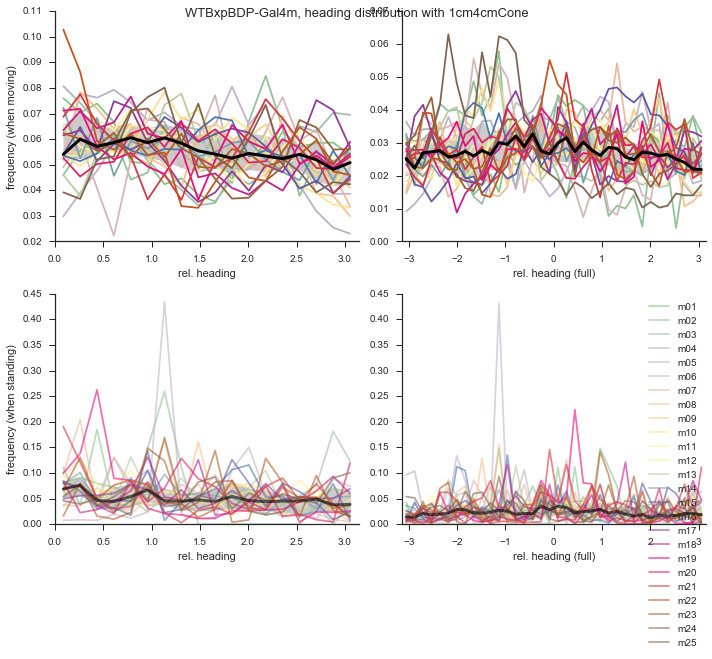

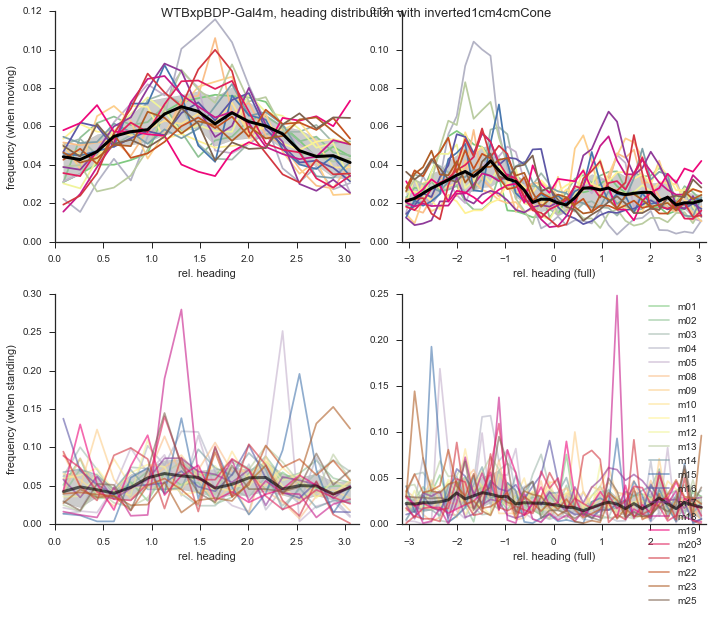

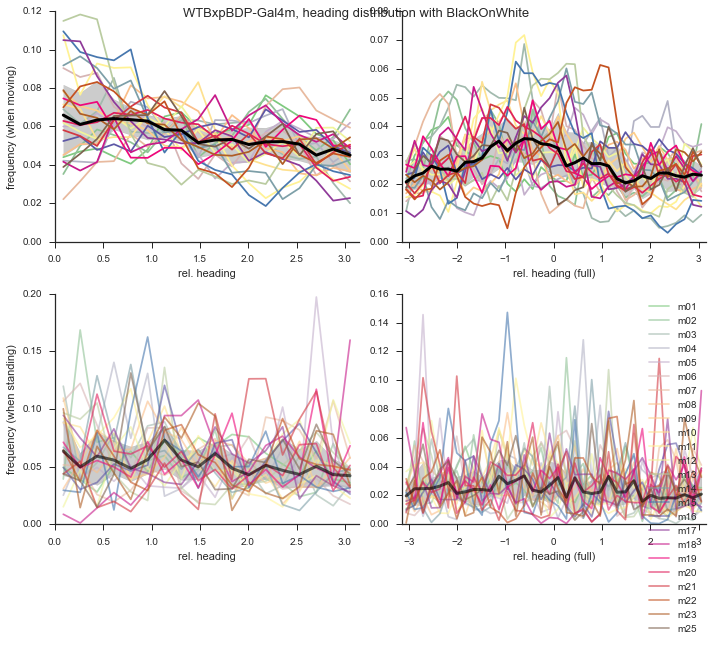

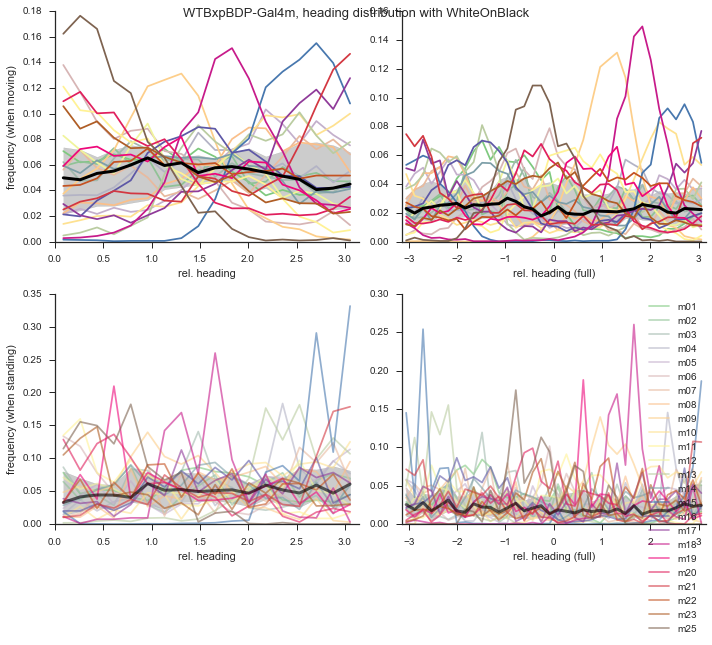

In [14]:
for scene in range(len(sceneNames)):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename+'\n')
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag,True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

1cm4cmCone
inverted1cm4cmCone
fly m06 not moving: 17.3333333333
fly m07 not moving: 16.8416666667
fly m24 not moving: 1.09166666667
BlackOnWhite
fly m24 not moving: 15.2833333333
WhiteOnBlack
fly m24 not moving: 14.2


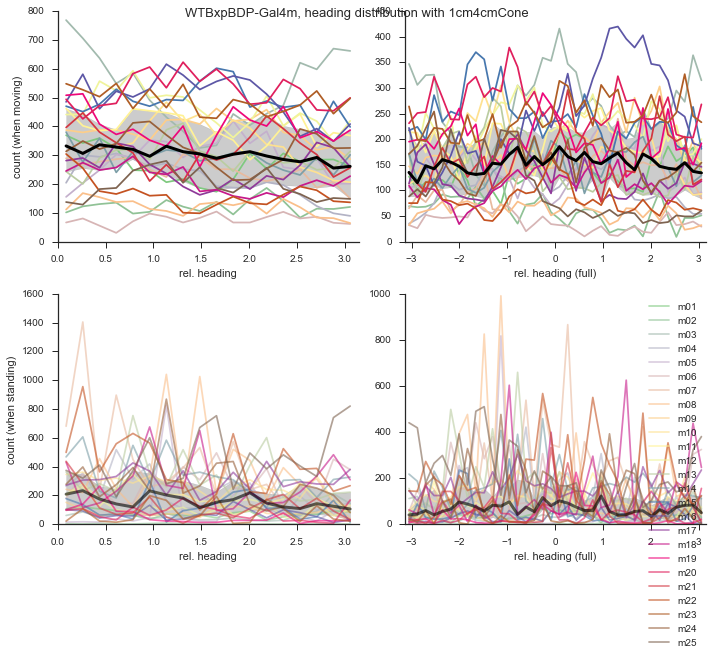

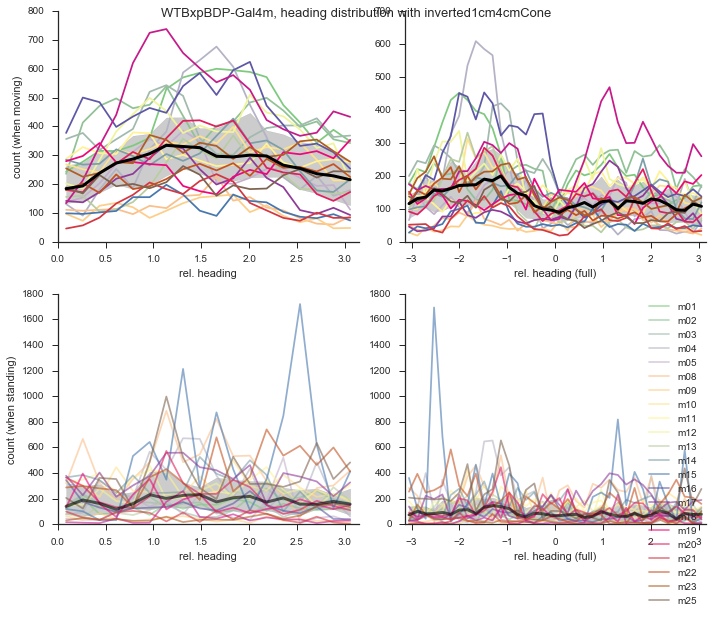

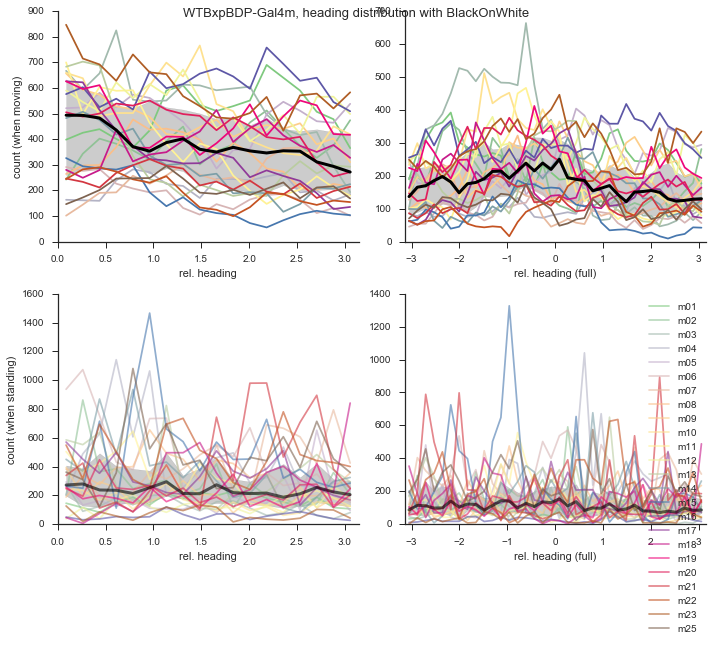

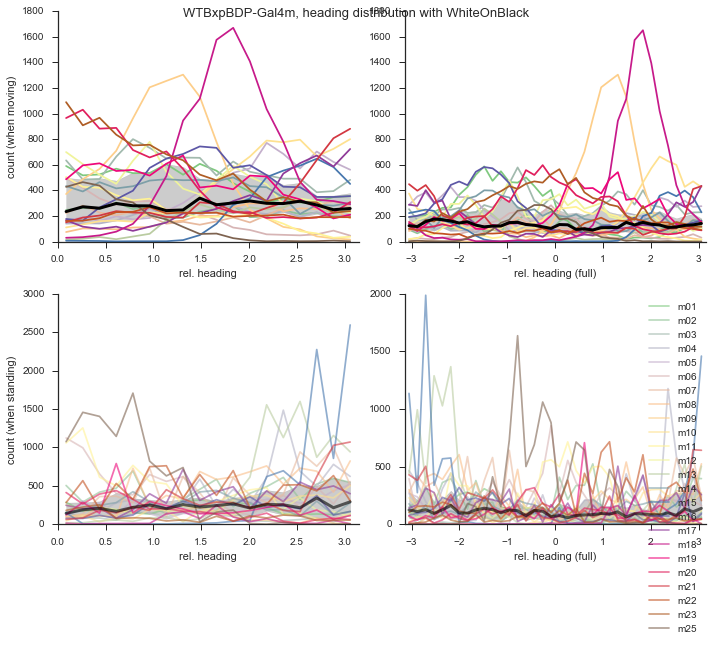

In [15]:
for scene in range(len(sceneNames)):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename)
    
    densityFlag = False
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag,True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

## Comparison between relative heading and absolute heading in 2D worlds (they are the same in 1D)

In [16]:
def plot2DHeadingComparison(sceneName,titleString,densityFlag,plotIQR):
    legendlist = []
    fullBins = 36
    histRange = (-np.pi, np.pi)

    nhead_angle = np.nan*np.ones((numFlies,fullBins))
    nhead_gamma = np.nan*np.ones((numFlies,fullBins))
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'

        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()
        angle = FOAllFlies_df.query(querystring).iloc[:,keyind_ang:keyind_ang+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()
        
        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+  str(100.0*sum(moving)/max(1,len(moving))))
            
            continue
            
        legendlist.append(flyIDs[fly])

        # rel. heading
        gammaPlt = headingfig.add_subplot(121)
        nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=fullBins)
        gammaPlt.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt.set_ylabel('frequency (when moving)')
            normFactor = nhead.sum()
        else:
            gammaPlt.set_ylabel('count (when moving)')
            normFactor = 1.0
        gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaPlt.set_xlim(histRange)
        myAxisTheme(gammaPlt)
        
        nhead_gamma[fly,:] = nhead/normFactor
        fulledges = edges[:-1]+np.diff(edges)/2

        # abs. heading
        anglePlt = headingfig.add_subplot(122)
        nhead, edges = np.histogram(angle[moving>0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        anglePlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        anglePlt.set_xlim(histRange)
        anglePlt.set_xlabel('abs. heading')
        myAxisTheme(anglePlt)
        
        nhead_angle[fly,:] = nhead/normFactor
        fulledges = edges[:-1]+np.diff(edges)/2

    headingfig.suptitle(titleString,fontsize=13)
    anglePlt.legend(legendlist)
    headingfig.tight_layout()
    
    gammaPlt.plot(fulledges,np.nanmedian(nhead_gamma[:,:],0),color='k',linewidth=3)
    anglePlt.plot(fulledges,np.nanmedian(nhead_angle[:,:],0),color='k',linewidth=3)
    
    if(plotIQR):
        [var1,var2] = np.nanpercentile(nhead_gamma[:,:],[25,75],axis=0)
        gammaPlt.fill_between(fulledges, var1, var2, color='k', alpha=0.2)
        
        [var1,var2] = np.nanpercentile(nhead_angle[:,:],[25,75],axis=0)
        anglePlt.fill_between(fulledges, var1, var2, color='k', alpha=0.2)

    return headingfig

1cm4cmCone

inverted1cm4cmCone

fly m06 not moving: 17.3333333333
fly m07 not moving: 16.8416666667
fly m24 not moving: 1.09166666667


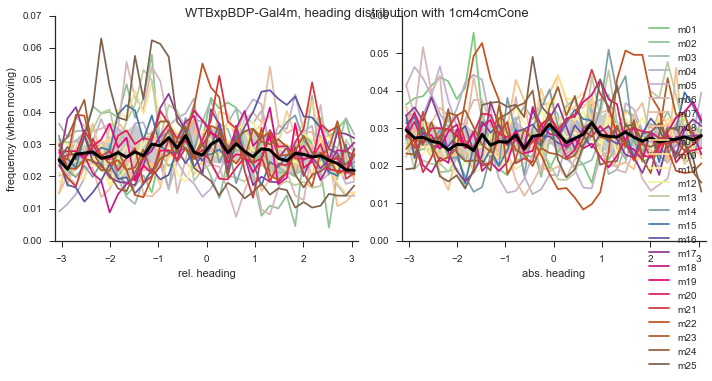

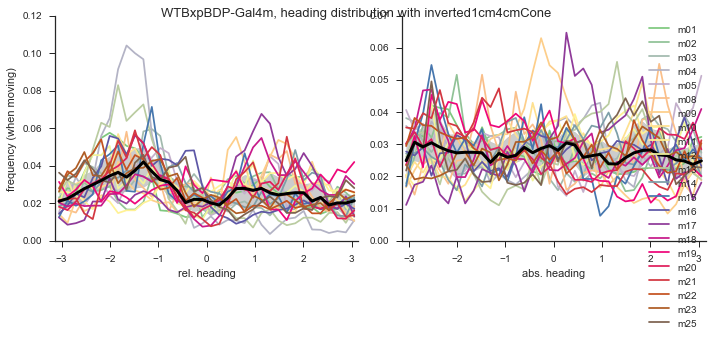

In [17]:
for scene in [0,1]:
    headingfig = plt.figure(figsize=(10,4))

    scenename = sceneNames[scene]
    print(scenename+'\n')
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plot2DHeadingComparison(scenename,titleString,densityFlag,True)

    #headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

## Compute circular statistics on heading distribution

In [18]:
# Modified function circmean from scipy.stats package. Added calculation of mean vector length

def _circfuncs_common(samples, high, low):
    samples = np.asarray(samples)
    if samples.size == 0:
        return np.nan, np.nan

    ang = (samples - low)*2*np.pi / (high - low)
    return samples, ang


def circmeanvec(samples, weights, high=2*np.pi, low=0, axis=None):
    """
    Compute the circular mean for samples in a range.
    Parameters
    ----------
    samples : array_like
        Input array.
    weights: array_like
        Input array with weights (i.e. vector lengths)
    high : float or int, optional
        High boundary for circular mean range.  Default is ``2*pi``.
    low : float or int, optional
        Low boundary for circular mean range.  Default is 0.
    axis : int, optional
        Axis along which means are computed.  The default is to compute
        the mean of the flattened array.
    Returns
    -------
    circmean : float
        Circular mean direction
        Ciruclar mean length
    """
    samples, ang = _circfuncs_common(samples, high, low)
    
    try:
        N = len(ang)
    except:
        print('problem with sample')
        print(samples)
        
        return np.nan, np.nan
        
    S = (weights*np.sin(ang)).sum(axis=axis)
    C = (weights*np.cos(ang)).sum(axis=axis)
    res = np.arctan2(S, C)
    mask = res < 0
    if mask.ndim > 0:
        res[mask] += 2*np.pi
    elif mask:
        res += 2*np.pi
    direction = res*(high - low)/2.0/np.pi + low
    
    length = np.sqrt( np.square(C) + np.square(S) )/len(weights)
    
    return direction, length

"""Demo of polar plot of arbitrary theta. This is a workaround for MPL's polar plot limitation
to a full 360 deg.
Based on http://matplotlib.org/mpl_toolkits/axes_grid/examples/demo_floating_axes.py
"""

from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.transforms import Affine2D
from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist import angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from mpl_toolkits.axisartist.floating_axes import GridHelperCurveLinear, FloatingSubplot


def fractional_polar_axes(f, thlim=(0, 180), rlim=(0, 1), step=(30, 0.2),
                          thlabel='theta', rlabel='r', ticklabels=True, subplotloc=(1,1,1)):
    """Return polar axes that adhere to desired theta (in deg) and r limits. steps for theta
    and r are really just hints for the locators. Using negative values for rlim causes
    problems for GridHelperCurveLinear for some reason"""
    th0, th1 = thlim # deg
    r0, r1 = rlim
    thstep, rstep = step

    # scale degrees to radians:
    tr_scale = Affine2D().scale(np.pi/180., 1.)
    tr = tr_scale + PolarAxes.PolarTransform()
    theta_grid_locator = angle_helper.LocatorDMS((th1-th0) // thstep)
    r_grid_locator = MaxNLocator((r1-r0) // rstep)
    theta_tick_formatter = angle_helper.FormatterDMS()
    grid_helper = GridHelperCurveLinear(tr,
                                        extremes=(th0, th1, r0, r1),
                                        grid_locator1=theta_grid_locator,
                                        grid_locator2=r_grid_locator,
                                        tick_formatter1=theta_tick_formatter,
                                        tick_formatter2=None)

    a = FloatingSubplot(f, subplotloc, grid_helper=grid_helper)
    f.add_subplot(a)

    # adjust x axis (theta):
    a.axis["bottom"].set_visible(False)
    a.axis["top"].set_axis_direction("bottom") # tick direction
    a.axis["top"].toggle(ticklabels=ticklabels, label=bool(thlabel))
    a.axis["top"].major_ticklabels.set_axis_direction("top")
    a.axis["top"].label.set_axis_direction("top")

    # adjust y axis (r):
    a.axis["left"].set_axis_direction("bottom") # tick direction
    a.axis["right"].set_axis_direction("top") # tick direction
    a.axis["left"].toggle(ticklabels=ticklabels, label=bool(rlabel))

    # add labels:
    a.axis["top"].label.set_text(thlabel)
    a.axis["left"].label.set_text(rlabel)

    # create a parasite axes whose transData is theta, r:
    auxa = a.get_aux_axes(tr)
    # make aux_ax to have a clip path as in a?:
    auxa.patch = a.patch 
    # this has a side effect that the patch is drawn twice, and possibly over some other
    # artists. So, we decrease the zorder a bit to prevent this:
    a.patch.zorder = -2

    # add sector lines for both dimensions:
    thticks = grid_helper.grid_info['lon_info'][0]
    rticks = grid_helper.grid_info['lat_info'][0]
    for th in thticks[1:-1]: # all but the first and last
        auxa.plot([th, th], [r0, r1], '--', c='grey', zorder=-1)
    for ri, r in enumerate(rticks):
        # plot first r line as axes border in solid black only if it isn't at r=0
        if ri == 0 and r != 0:
            ls, lw, color = 'solid', 2, 'black'
        else:
            ls, lw, color = 'dashed', 1, 'grey'
        # From http://stackoverflow.com/a/19828753/2020363
        auxa.add_artist(plt.Circle([0, 0], radius=r, ls=ls, lw=lw, color=color, fill=False,
                        transform=auxa.transData._b, zorder=-1))
    return auxa

In [19]:
angleLow = -np.pi
angleHigh = np.pi

headingPVA = np.nan*np.ones((len(sceneNames),numFlies,2))
anglePVA = np.nan*np.ones((len(sceneNames),numFlies,2))
fliesNotWalking = np.zeros((len(sceneNames)))

from scipy.stats import circmean as circmean
#from scipy.stats import circvar as circvar
for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]
    print('\n'+scenename+'\n')
    
    for fly in range(numFlies):

        querystring = '(sceneName=="' + scenename + '") & (flyID =="' + flyIDs[fly] +  '")'
        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

        perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values
        perFlyA = FOAllFlies_df.query(querystring).iloc[:,keyind_ang:keyind_ang+1].squeeze().astype('float').values

        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))
            fliesNotWalking[scene] += 1
            
            continue
        gamFul = perFlyG[moving>0]
        meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

        headingPVA[scene,fly,0] = meandir
        headingPVA[scene,fly,1] = meanlen
        
        angle = perFlyA[moving>0]
        meandir, meanlen = circmeanvec(angle[~np.isnan(angle)],np.ones(len(angle[~np.isnan(angle)])), high=angleHigh, low=angleLow)

        anglePVA[scene,fly,0] = meandir
        anglePVA[scene,fly,1] = meanlen
        
try:
    mkdir(analysisDir + sep + 'circStats' + sep)
except OSError:
    print('Analysis directory already exists.')
        
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_dir_'+scenename+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_len_'+scenename+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,:,1], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_dir_'+scenename+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_len_'+scenename+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,:,1], delimiter=',')


1cm4cmCone


inverted1cm4cmCone

fly m06 not moving: 17.3333333333
fly m07 not moving: 16.8416666667
fly m24 not moving: 1.09166666667

BlackOnWhite

fly m24 not moving: 15.2833333333

WhiteOnBlack

fly m24 not moving: 14.2
Analysis directory already exists.


In [20]:
#trialCol = ['black','grey','darkblue','steelblue']
#
#for scene in range(len(sceneNames)):
#    scenename = sceneNames[scene]

#    PVAFig = plt.figure(figsize=(5,5))
#    polplt = fractional_polar_axes(PVAFig, thlim=(angleLow*(180/np.pi), angleHigh*(180/np.pi)), rlim=(0,1), step=(30, 0.25),
#                                  thlabel = 'heading PVA, ' + scenename + ', n='+str(numFlies), rlabel='PVA length',subplotloc='1'+'1'+str(1))
#    polplt.plot(headingPVA[scene,:,0]*(180.0/np.pi),headingPVA[scene,:,1],'o', color=trialCol[scene],alpha=0.7, markersize=10)

#    meandir, meanlen = circmeanvec(headingPVA[scene,~np.isnan(headingPVA[scene,:,0]),0],\
#                                   headingPVA[scene,~np.isnan(headingPVA[scene,:,0]),1],\
#                                   high=angleHigh, low=angleLow)
#    polplt.plot(meandir*(180.0/np.pi),meanlen,'o',color='darkred',alpha=1, markersize=12)

#    PVAFig.savefig(analysisDir + 'circStats/'  + genotype
#                   + '_headingPVA_v1_'+scenename+'_n'+ str(numFlies) +'.pdf', format='pdf')

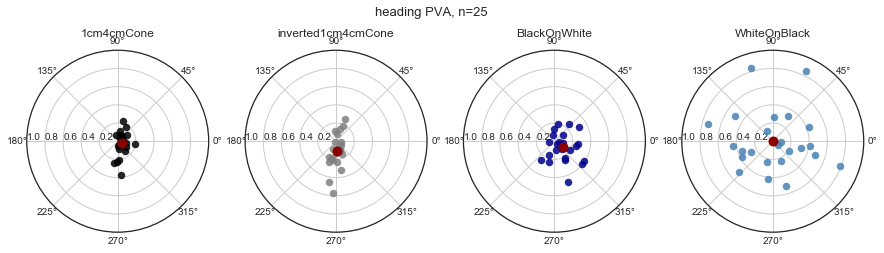

In [21]:
trialCol = ['black','grey','darkblue','steelblue']

PVAFig = plt.figure(figsize=(15,4))

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]    

    ax = PVAFig.add_subplot(1,len(sceneNames),scene+1,projection='polar')
    ax.plot(headingPVA[scene,:,0],headingPVA[scene,:,1],'.',markersize=15,color=trialCol[scene],alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,~np.isnan(headingPVA[scene,:,0]),0],\
                                   headingPVA[scene,~np.isnan(headingPVA[scene,:,0]),1],\
                                   high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,1)
    ax.set_rlabel_position(180)
    ax.set_title(scenename)

PVAFig.suptitle('heading PVA, n='+str(numFlies),fontsize=13)
PVAFig.savefig(analysisDir + 'circStats/'  + genotype
                + '_headingPVA_n'+ str(numFlies) +'.pdf', format='pdf') 

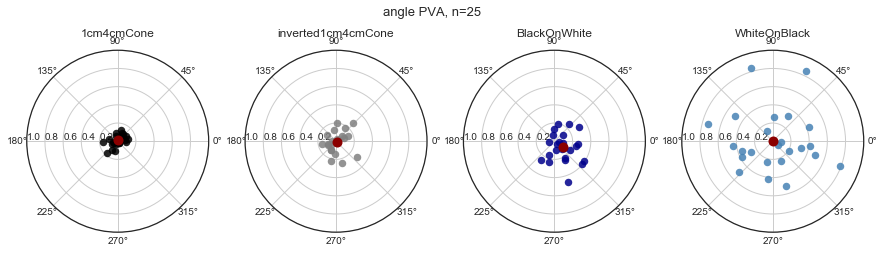

In [22]:
PVAFig = plt.figure(figsize=(15,4))

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]    

    ax = PVAFig.add_subplot(1,len(sceneNames),scene+1,projection='polar')
    ax.plot(anglePVA[scene,:,0],anglePVA[scene,:,1],'.',markersize=15,color=trialCol[scene],alpha=0.85)
    meandir, meanlen = circmeanvec(anglePVA[scene,~np.isnan(anglePVA[scene,:,0]),0],\
                                   anglePVA[scene,~np.isnan(anglePVA[scene,:,0]),1],\
                                   high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,1)
    ax.set_rlabel_position(180)
    ax.set_title(scenename)

PVAFig.suptitle('angle PVA, n='+str(numFlies),fontsize=13)
PVAFig.savefig(analysisDir + 'circStats/'  + genotype
                + '_anglePVA_n'+ str(numFlies) +'.pdf', format='pdf') 

## Fit von Mises distribution

In [23]:
from scipy import stats as sts
from scipy.optimize import curve_fit

def sineFunc(x, a, b):
    y = (np.sin((x-a))*b) + b
    y = y/sum(y*np.mean(np.diff(x)))
    return y

def vMFunc(x, mu, kappa):
    return np.exp(kappa * np.cos(x-mu)) / (2*np.pi*np.i0(kappa))

def vMbiModFunc(x, mu1, mu2, kappa):
    return ( (np.exp(kappa * np.cos(x-mu1)) / (2*np.pi*np.i0(kappa))) + (np.exp(kappa * np.cos(x-mu2)) / (2*np.pi*np.i0(kappa))) )/2

[ 0.74180519  0.06154343]


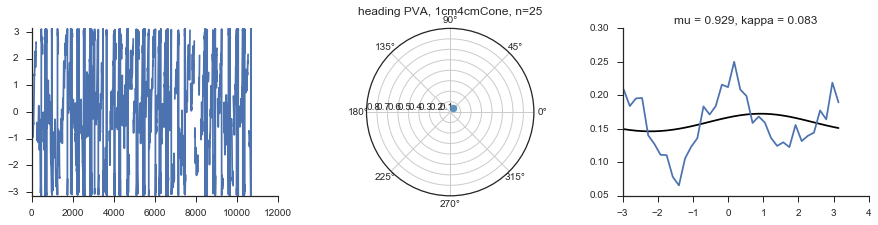

In [24]:
sceneName = sceneNames[0]
fly = 2

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

if sum(moving)<=0.2*len(moving):
    print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

gamFul = perFlyG[moving>0] #+ np.pi
meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)
    
fitFig = plt.figure(figsize=(15,3))
ax = fitFig.add_subplot(131)
ax.plot(gamFul)
ax.set_ylim(angleLow, angleHigh)
myAxisTheme(ax)
ax2 = fitFig.add_subplot(132,projection='polar')
ax2.plot(meandir, meanlen,'.',markersize=15,color='steelblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
ax2.set_rlim(0,0.8)
ax2.set_rlabel_position(180)
ax2.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))

bins = np.linspace(angleLow, angleHigh, 37)
x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(gamFul,bins, normed=True)

meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
perr = np.sqrt(np.diag(pcov))
print(perr)

mu = popt[0]
kappa = popt[1]
yhat = vMFunc(x,mu,kappa)

ax = fitFig.add_subplot(133)
ax.plot(x,yhat,'k')
ax.plot(x,n)
ax.set_title('mu = '+str(round(mu,3))+', kappa = '+str(round(kappa,3)))
myAxisTheme(ax)


[ 0.04627655  0.04627655  0.06576359]


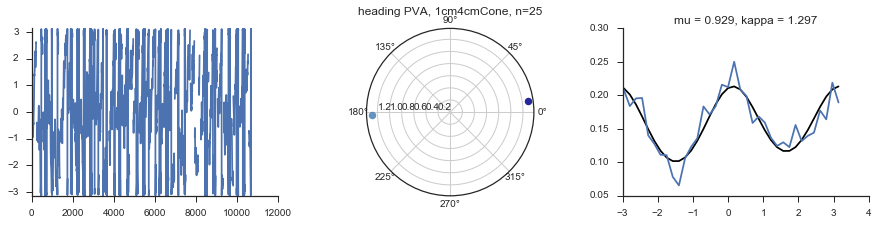

In [25]:
sceneName = sceneNames[0]
fly = 2

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

if sum(moving)<=0.2*len(moving):
    print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

gamFul = perFlyG[moving>0]

fitFig = plt.figure(figsize=(15,3))
ax = fitFig.add_subplot(131)
ax.plot(gamFul)
ax.set_ylim(angleLow, angleHigh)
myAxisTheme(ax)

bins = np.linspace(angleLow, angleHigh, 37)
x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(gamFul,bins, normed=True)

meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

popt, pcov = curve_fit(vMbiModFunc, x, n , p0=[-np.pi/2, np.pi/2, meanlen_freq], bounds=([-np.pi, -np.pi, 0], [np.pi, np.pi, np.inf]))
perr = np.sqrt(np.diag(pcov))
print(perr)

mu1 = popt[0]
mu2 = popt[1]
kappa = popt[2]

yhat = vMbiModFunc(x, mu1, mu2, kappa)

ax2 = fitFig.add_subplot(132,projection='polar')
ax2.plot(mu1, kappa,'.',markersize=15,color='steelblue',alpha=0.85)
ax2.plot(mu2, kappa,'.',markersize=15,color='darkblue',alpha=0.85)
meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
#ax2.set_rlim(0,0.8)
ax2.set_rlabel_position(180)
ax2.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))

ax = fitFig.add_subplot(133)
ax.plot(x,yhat,'k')
ax.plot(x,n)
ax.set_title('mu = '+str(round(mu,3))+', kappa = '+str(round(kappa,3)))
myAxisTheme(ax)


### Fit unimodal von Mises

fly m06 not moving: 17.3333333333
fly m07 not moving: 16.8416666667
fly m24 not moving: 1.09166666667
fly m24 not moving: 15.2833333333
fly m24 not moving: 14.2


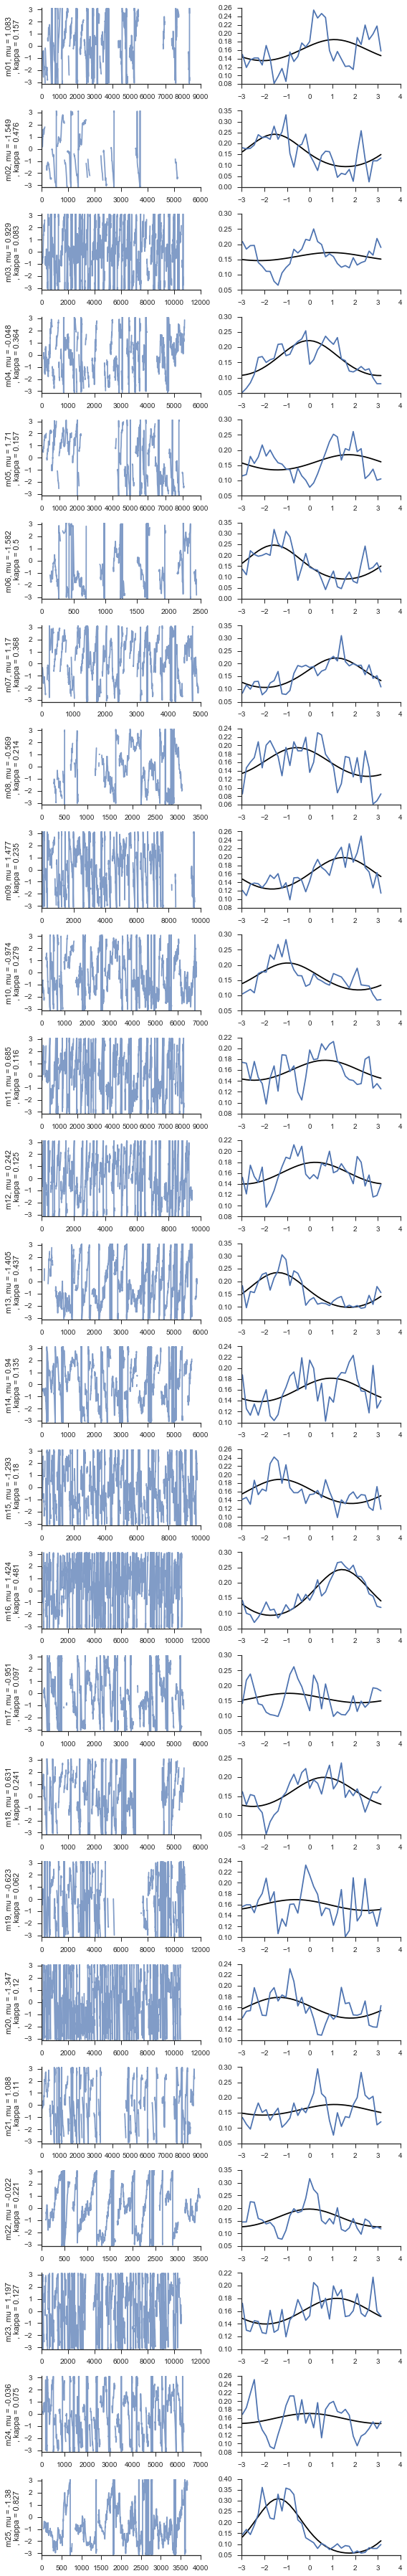

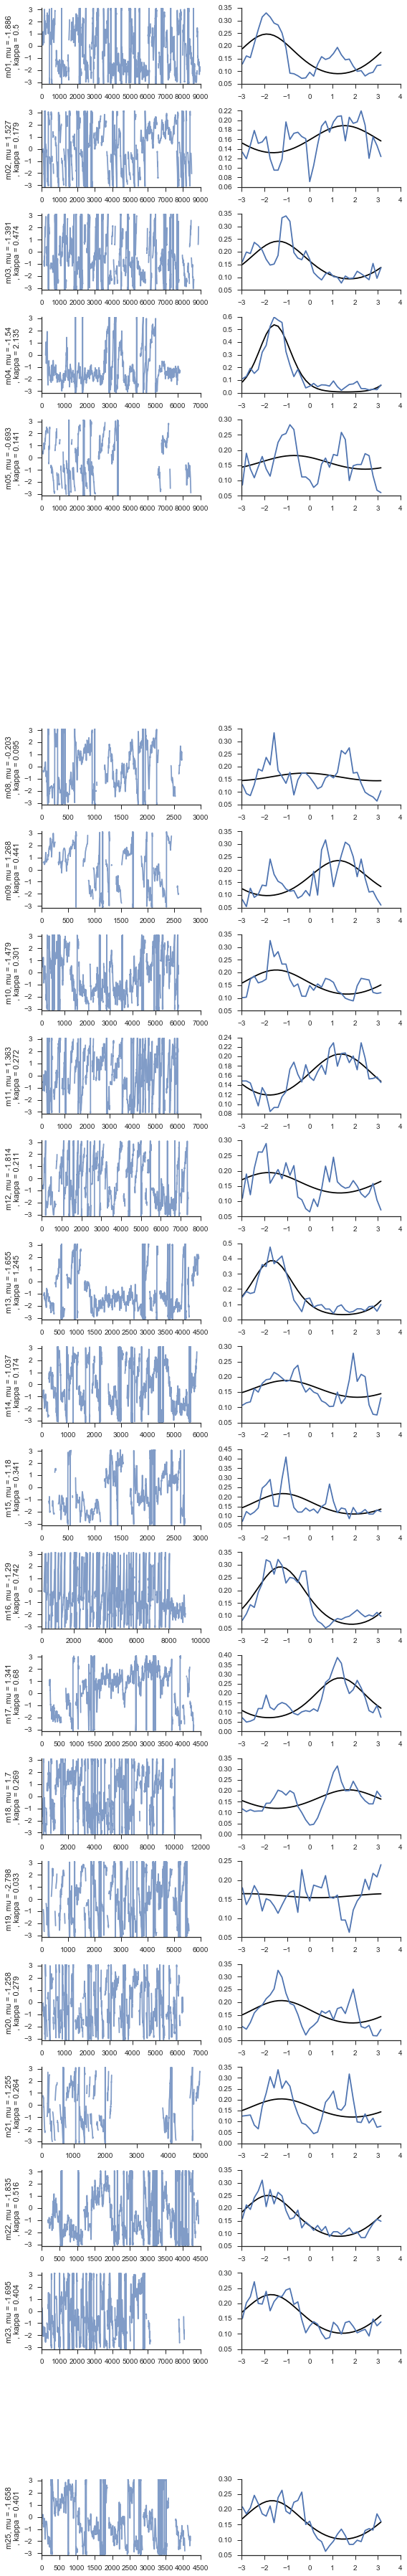

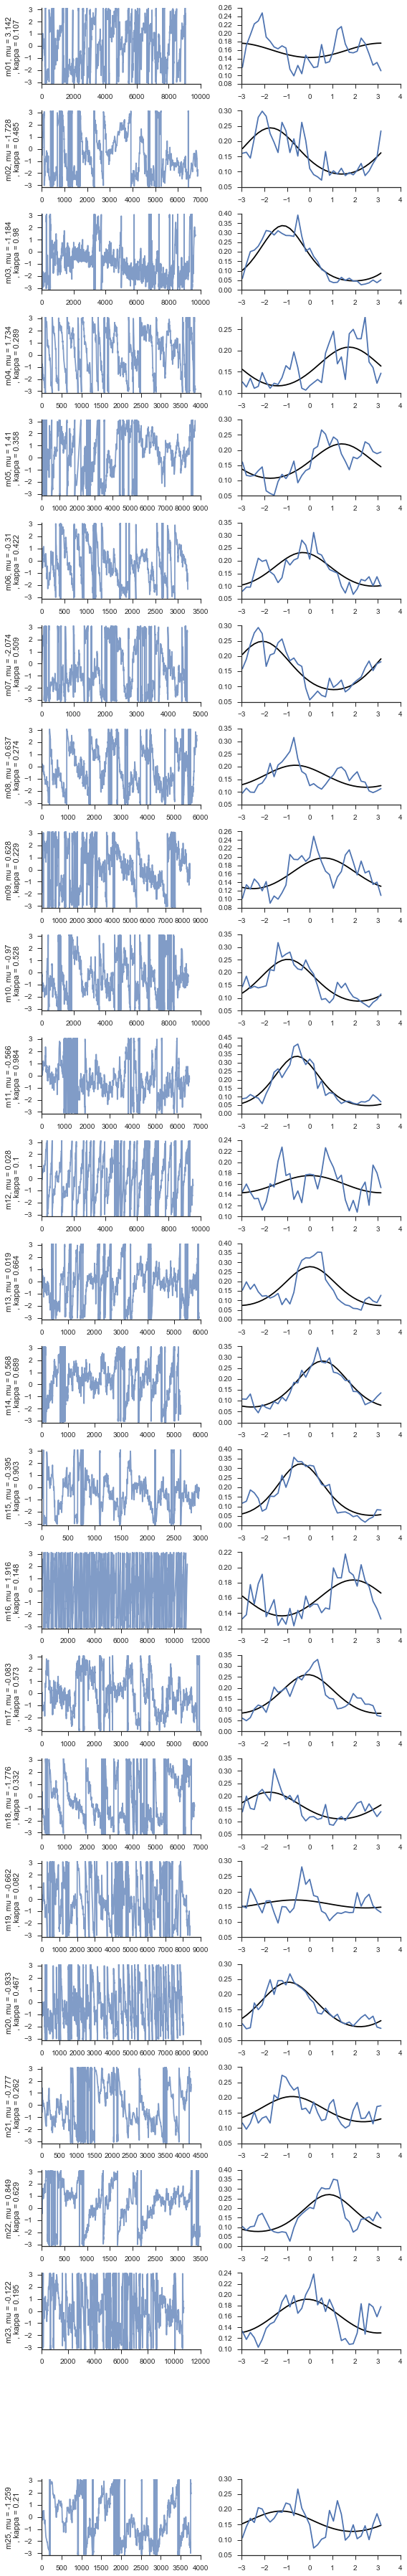

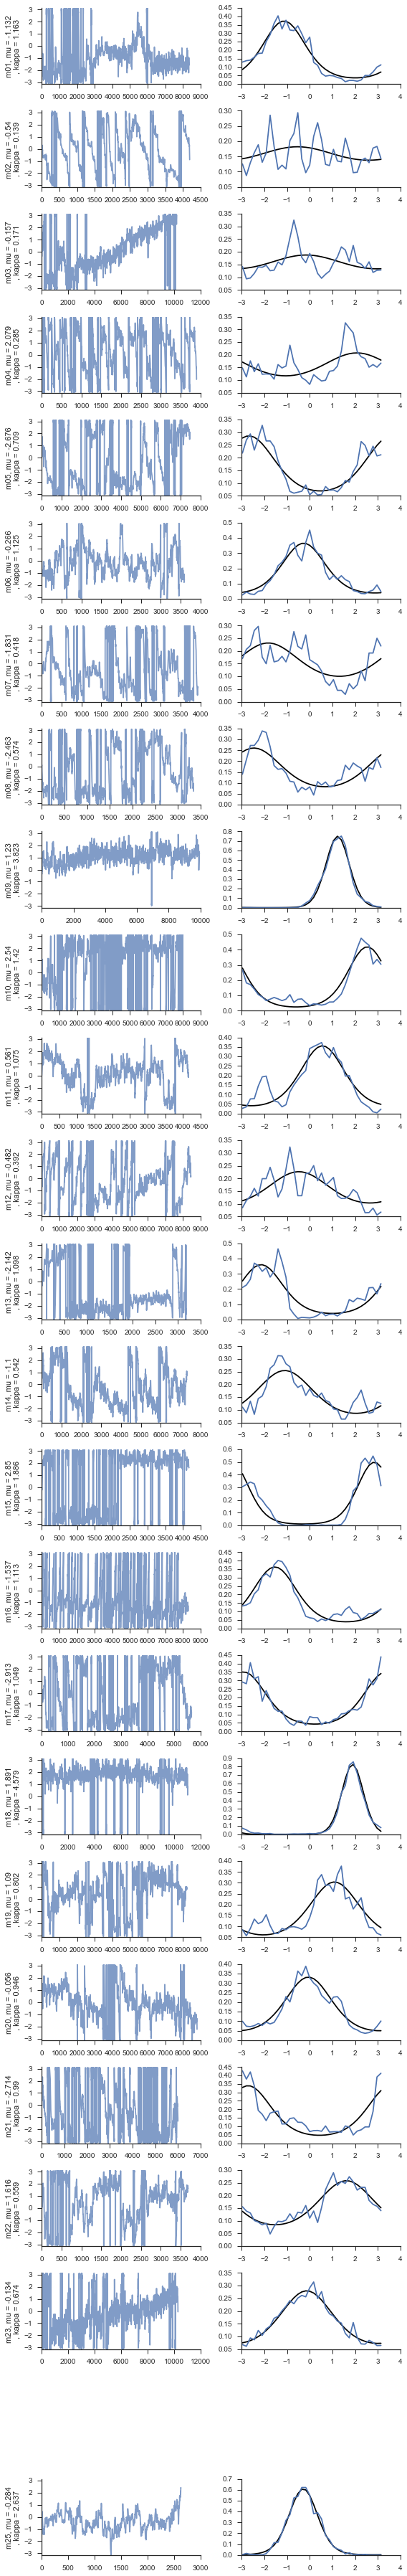

In [26]:
angleLow = -np.pi
angleHigh = np.pi

#bins size
binwidth = 10 #deg
numFlies = len(flyIDs)
vmfits = np.nan*np.ones((len(sceneNames),5,numFlies))

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(8,2*numFlies))
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

        perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

            continue

        gamFul = perFlyG[moving>0]

        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins, normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
        mu = popt[0]
        kappa = popt[1]
        yhat = vMFunc(x,mu,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmfits[scene,0,fly] = mu
        vmfits[scene,1,fly] = kappa
        vmfits[scene,2,fly] = sqd
        vmfits[scene,3,fly] = p
        vmfits[scene,4,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(numFlies,2,1+fly*2)
        ax.plot(gamFul,alpha=0.7)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
        myAxisTheme(ax)

        ax = fitFig.add_subplot(numFlies,2,2+fly*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        myAxisTheme(ax)

    fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFit_n'+ str(numFlies) +'.pdf', format='pdf') 

1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m01', 'm03', 'm05', 'm11', 'm14', 'm17', 'm19', 'm21', 'm22', 'm24']
flies with large summed squared error:
['m02', 'm22']
inverted1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m04', 'm05', 'm08', 'm12', 'm14', 'm18', 'm19', 'm20', 'm21']
flies with large summed squared error:
['m01', 'm04', 'm05', 'm08', 'm09', 'm12', 'm15', 'm17', 'm18', 'm20', 'm21']
BlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m01', 'm12', 'm19']
flies with large summed squared error:
['m13', 'm22']
WhiteOnBlack
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m02', 'm03', 'm13', 'm15', 'm18']
flies with large summed squared error:
['m02', 'm04', 'm07', 'm11', 'm13', 'm15', 'm21']


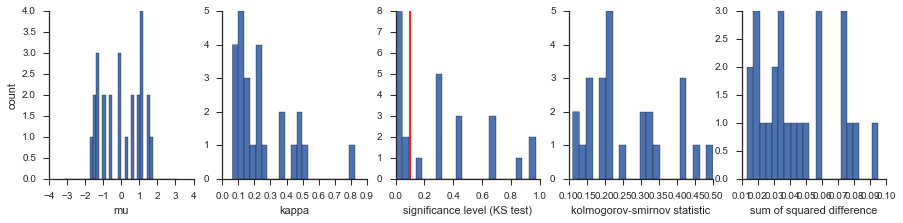

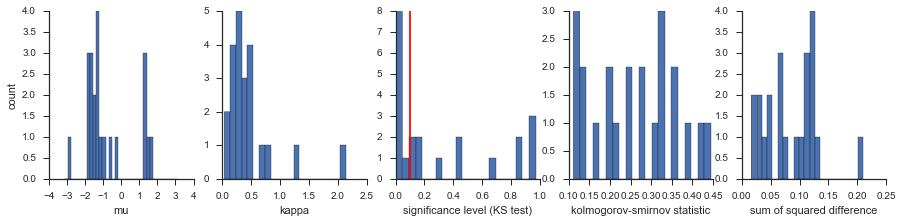

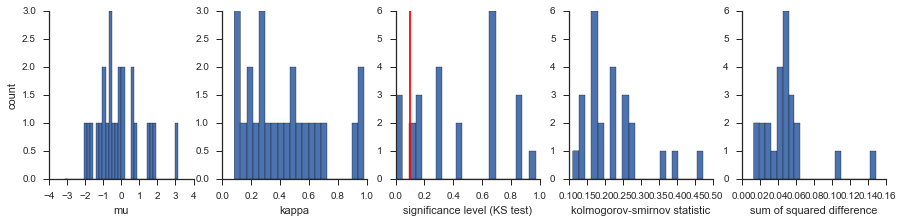

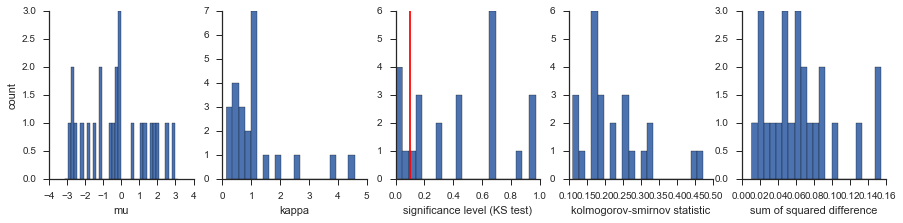

In [27]:
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(15,3))

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    muax = fitFig.add_subplot(151)
    muax.hist(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins)
    #muax.set_xlim(-np.pi, np.pi)
    muax.set_ylabel('count')
    muax.set_xlabel('mu')
    myAxisTheme(muax)

    bins = np.linspace(0, 2, 21)
    kapax = fitFig.add_subplot(152)
    kapax.hist(vmfits[scene,1,~np.isnan(vmfits[scene,1,:])],len(bins))
    #kapax.set_xlim(0, 2)
    kapax.set_xlabel('kappa')
    myAxisTheme(kapax)

    bins = np.linspace(0, 1, 21)
    pax = fitFig.add_subplot(153)
    pax.hist(vmfits[scene,3,~np.isnan(vmfits[scene,3,:])],len(bins))
    pax.set_xlim(0, 1)
    pax.axvline(0.1,color='red')
    pax.set_xlabel('significance level (KS test)')

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(154)
    ksax.hist(vmfits[scene,4,~np.isnan(vmfits[scene,4,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('kolmogorov-smirnov statistic')
    myAxisTheme(ksax)

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(155)
    ksax.hist(vmfits[scene,2,~np.isnan(vmfits[scene,2,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('sum of squared difference')
    myAxisTheme(ksax)

    print(sceneName)
    print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
    print([flyIDs[fly] for fly in np.where(vmfits[scene,3,:]<=0.1)[0]])

    print('flies with large summed squared error:')
    print([flyIDs[fly] for fly in np.where(vmfits[scene,2,:]>=0.08)[0]])

    myAxisTheme(pax)

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

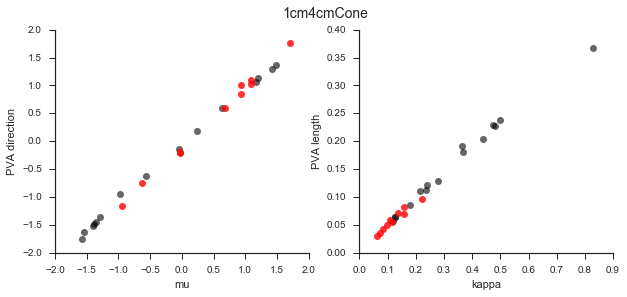

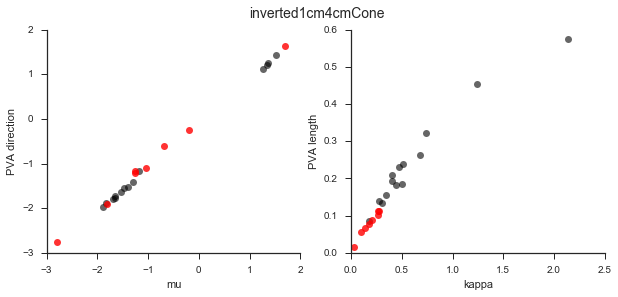

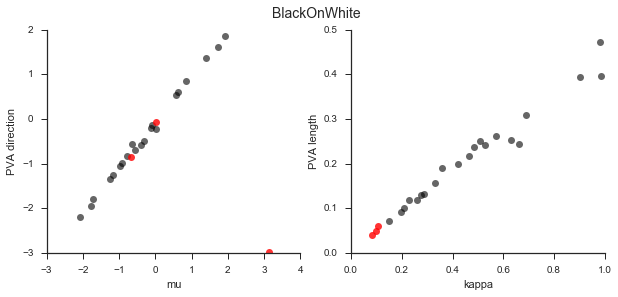

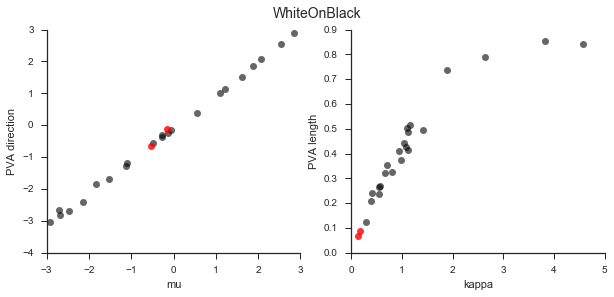

In [28]:
# Correlation between von Mieses fit and PVA
#Plot fit results
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    corrFig = plt.figure(figsize=(10,4))
    corrFig.suptitle(sceneName,fontsize=14)

    notFit = np.logical_and(np.logical_and(vmfits[scene,3,:]<=0.1, headingPVA[scene,:,1]<0.5),\
                            ~np.isnan(headingPVA[scene,:,1]))

    #correlation between mu and PVA direction
    muax = corrFig.add_subplot(121)
    muax.plot(vmfits[scene,0,~notFit],headingPVA[scene,~notFit,0],'ko',alpha=0.6)
    muax.plot(vmfits[scene,0,notFit],headingPVA[scene,notFit,0],'ro',alpha=0.8)
    muax.set_xlabel('mu'); muax.set_ylabel('PVA direction');
    myAxisTheme(muax)

    #correlation between kappa and PVA length
    kapax = corrFig.add_subplot(122)
    kapax.plot(vmfits[scene,1,~notFit],headingPVA[scene,~notFit,1],'ko',alpha=0.6)
    kapax.plot(vmfits[scene,1,notFit],headingPVA[scene,notFit,1],'ro',alpha=0.8)
    kapax.set_xlabel('kappa'); kapax.set_ylabel('PVA length');
    myAxisTheme(kapax)

    corrFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vM-vs-PVA_n'+ str(numFlies) +'.pdf', format='pdf') 

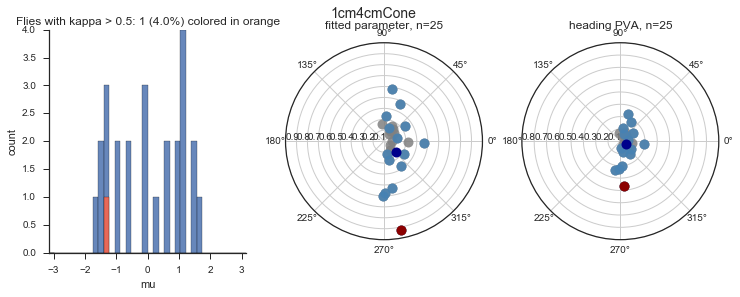

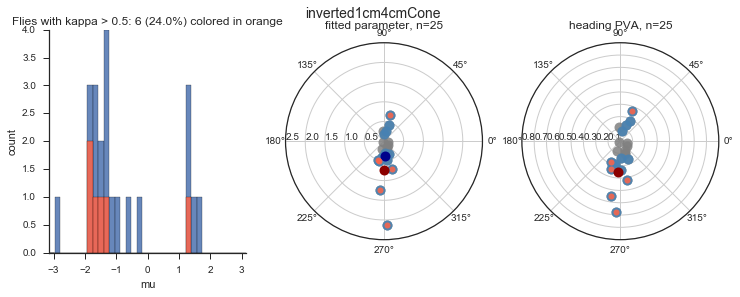

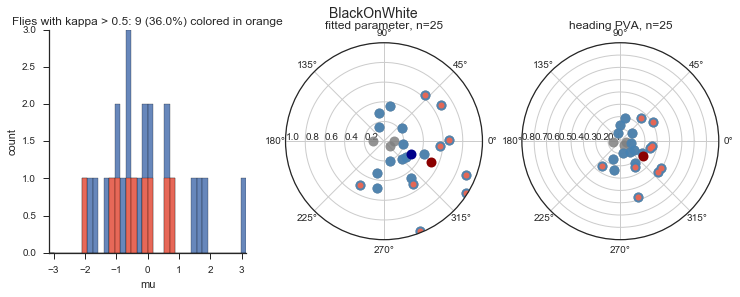

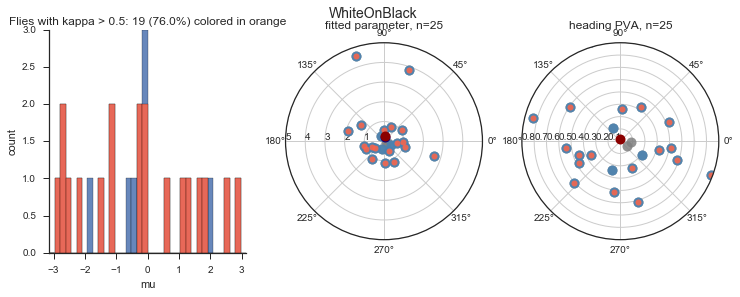

In [29]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))

    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    x = bins[:-1] + np.mean(np.diff(bins))
    [n,edg] = np.histogram(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins)
    [n_slct,edg] = np.histogram(vmfits[scene,0,slct],bins)

    #Plot fit results
    fixFig = plt.figure(figsize=(12,4))
    fixFig.suptitle(sceneName,fontsize=14)

    #histogram of fitted location (mu)
    muax = fixFig.add_subplot(131)
    muax.hist(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins,alpha=0.85)
    muax.hist(vmfits[scene,0,slct],bins,color='tomato',alpha=0.85)
    muax.set_xlim(-np.pi, np.pi)
    muax.set_xlabel('mu')
    muax.set_ylabel('count')
    muax.set_title('Flies with kappa > '+str(kappaTH)+': '+str(sum(vmfits[scene,1,:]>kappaTH))+' ('+\
                   str(round(100.0*sum(vmfits[scene,1,:]>kappaTH)/float(numFlies),3))+'%) colored in orange')
    myAxisTheme(muax)
    
    #polar plot of fitted location and shape parameter
    ax = fixFig.add_subplot(132,projection='polar')
    ax.plot(vmfits[scene,0,:],vmfits[scene,1,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    #ax.set_rlim(0,1)
    ax.set_rlabel_position(180)
    ax.set_title('fitted parameter, n='+str(numFlies))

    #polar plot of PVA
    ax = fixFig.add_subplot(133,projection='polar')
    ax.plot(headingPVA[scene,:,0],headingPVA[scene,:,1],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(headingPVA[scene,goodFit,0],headingPVA[scene,goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)

    ax.plot(headingPVA[scene,slct,0],headingPVA[scene,slct,1],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,slct,0],headingPVA[scene,slct,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,0.8)
    ax.set_rlabel_position(180)
    ax.set_title('heading PVA, n='+str(numFlies))
    
    #fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

### Fit bimodal von Mises to those distributions for which no good unimodal fit was found

1cm4cmCone
m01
m03
m05
m11
m14
m17
m19
m21
m22
m24
inverted1cm4cmCone
m05
m08
m12
m14
m18
m19
m20
m21
BlackOnWhite
m01
m12
m19
WhiteOnBlack
m02
m03


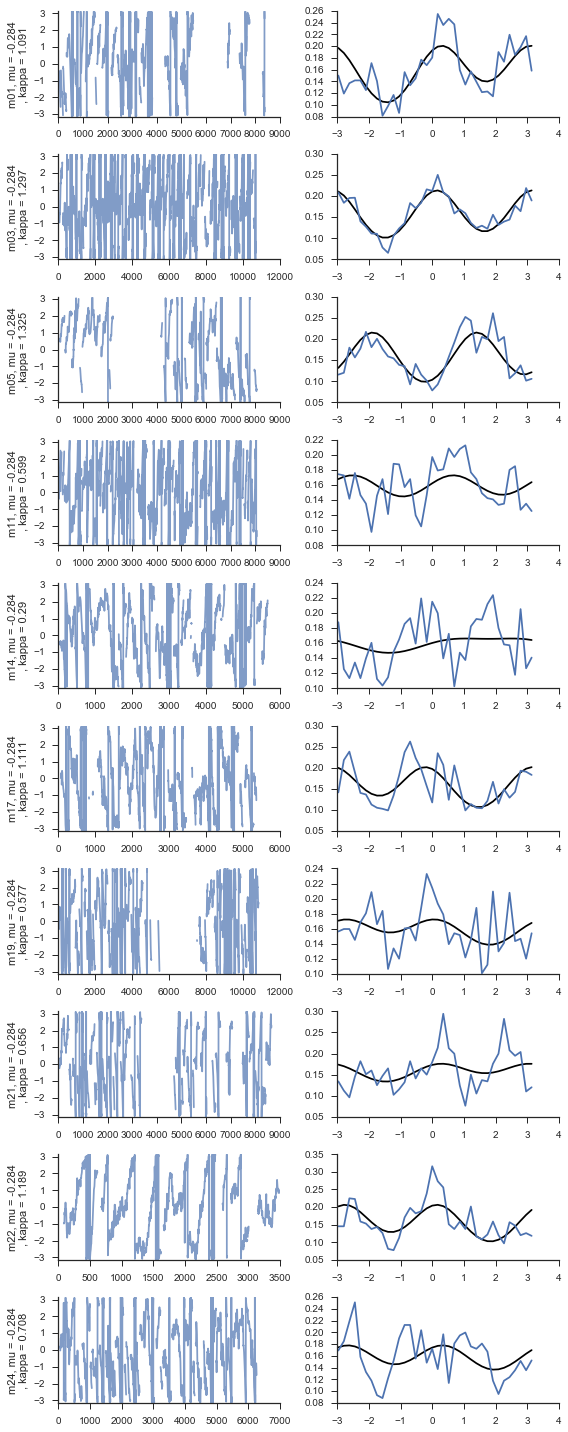

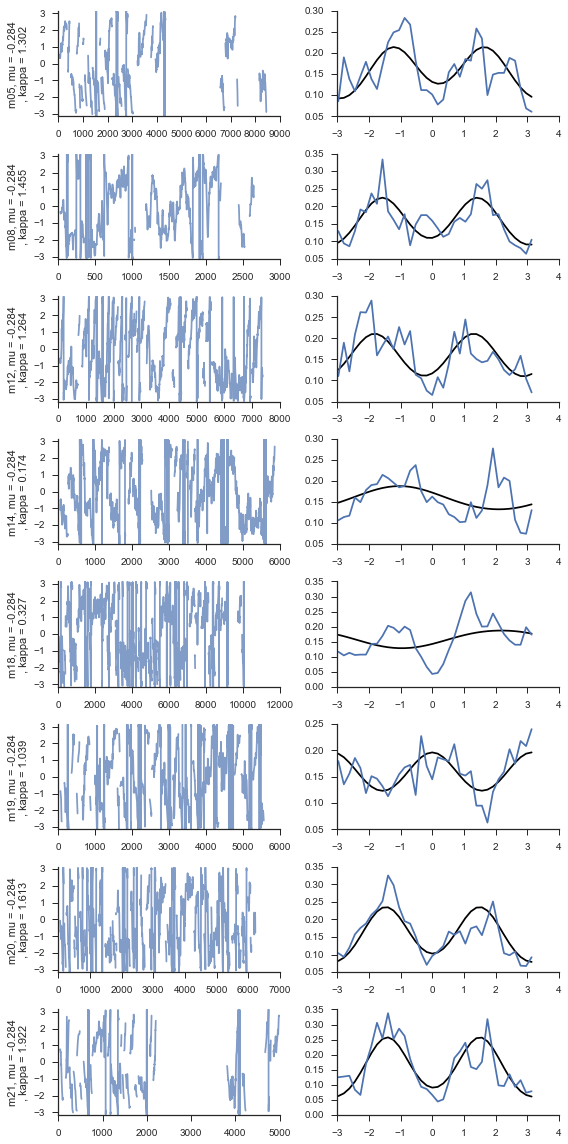

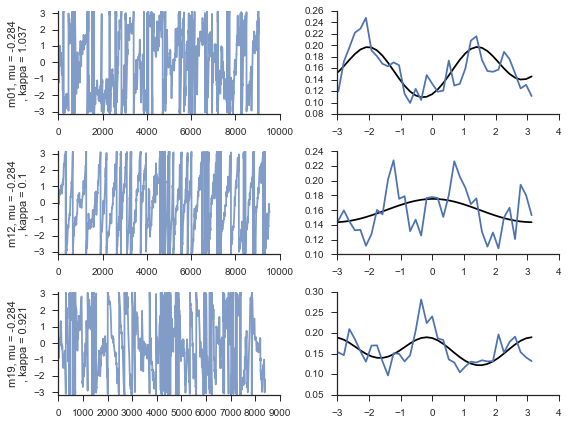

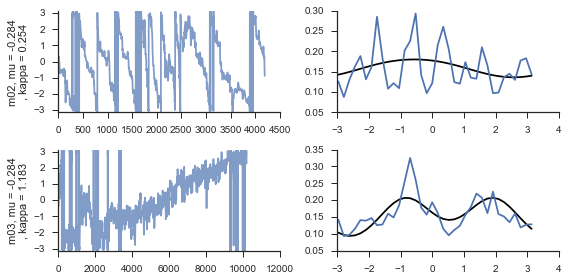

In [30]:
angleLow = -np.pi
angleHigh = np.pi

#bins size
binwidth = 10 #deg
numFlies = len(flyIDs)
vmbmfits = np.nan*np.ones((len(sceneNames),6,numFlies))

for scene, sceneName in enumerate(sceneNames):
    print(sceneName)
    
    noFit = np.logical_and(np.logical_and(vmfits[scene,3,:]<=0.1, headingPVA[scene,:,1]<0.5),\
                             ~np.isnan(headingPVA[scene,:,1]))
    
    notGoodFit = np.where(noFit>0)[0]
    
    if(len(notGoodFit)==0):
        continue
    
    fitFig = plt.figure(figsize=(8,2*len(notGoodFit)))
    
    for ind, fly in enumerate(notGoodFit):
        print(flyIDs[fly])
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int').values

        perFlyG = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze().astype('float').values

        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

            continue

        gamFul = perFlyG[moving>0]

        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins, normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        mu01 = np.nanmax(n)
        mu02 = np.mod(mu01+2*np.pi,2*np.pi)-np.pi
        
        popt, pcov = curve_fit(vMbiModFunc, x, n, p0=[mu01,mu02,meanlen_freq],\
                               bounds=([-np.pi, -np.pi, 0], [np.pi, np.pi, np.inf]))
        mu1 = popt[0]
        mu2 = popt[1]
        kappa = popt[2]
        yhat = vMbiModFunc(x,mu1,mu2,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmbmfits[scene,0,fly] = mu1
        vmbmfits[scene,1,fly] = mu2
        vmbmfits[scene,2,fly] = kappa
        vmbmfits[scene,3,fly] = sqd
        vmbmfits[scene,4,fly] = p
        vmbmfits[scene,5,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(len(notGoodFit),2,1+ind*2)
        ax.plot(gamFul,alpha=0.7)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
        myAxisTheme(ax)

        ax = fitFig.add_subplot(len(notGoodFit),2,2+ind*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        myAxisTheme(ax)

        fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMbiModFit_n'+ str(numFlies) +'.pdf', format='pdf') 

1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m11', 'm14', 'm19', 'm21', 'm24']
inverted1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m14', 'm18']
BlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m12']
WhiteOnBlack
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m02']


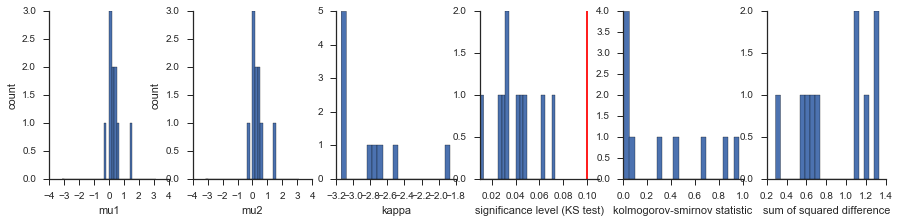

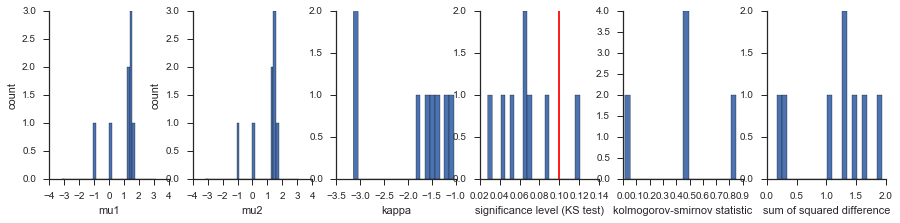

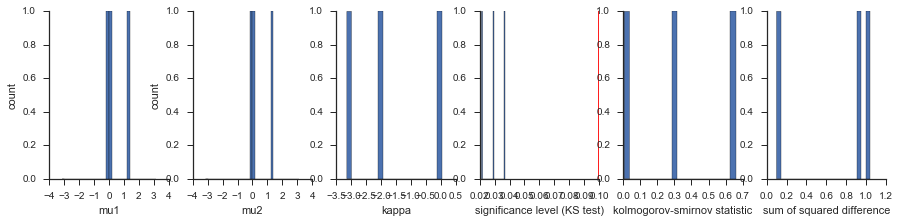

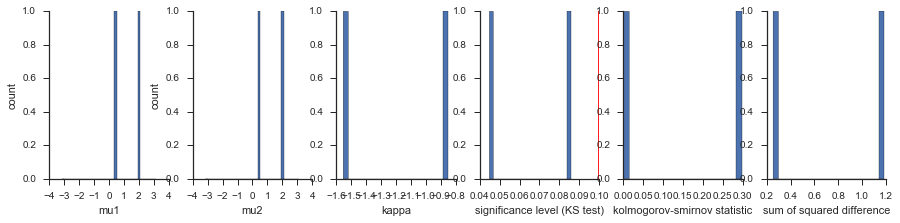

In [31]:
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(15,3))

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    muax = fitFig.add_subplot(161)
    muax.hist(vmbmfits[scene,0,~np.isnan(vmbmfits[scene,0,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu1')
    myAxisTheme(muax)
    
    muax = fitFig.add_subplot(162)
    muax.hist(vmbmfits[scene,0,~np.isnan(vmbmfits[scene,1,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu2')
    myAxisTheme(muax)

    bins = np.linspace(0, 2, 21)
    kapax = fitFig.add_subplot(163)
    kapax.hist(vmbmfits[scene,1,~np.isnan(vmbmfits[scene,2,:])],len(bins))
    kapax.set_xlabel('kappa')
    myAxisTheme(kapax)

    bins = np.linspace(0, 1, 21)
    pax = fitFig.add_subplot(164)
    pax.hist(vmbmfits[scene,3,~np.isnan(vmbmfits[scene,4,:])],len(bins))
    #pax.set_xlim(0, 1)
    pax.axvline(0.1,color='red')
    pax.set_xlabel('significance level (KS test)')

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(165)
    ksax.hist(vmbmfits[scene,4,~np.isnan(vmbmfits[scene,5,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('kolmogorov-smirnov statistic')
    myAxisTheme(ksax)

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(166)
    ksax.hist(vmbmfits[scene,2,~np.isnan(vmbmfits[scene,3,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('sum of squared difference')
    myAxisTheme(ksax)

    print(sceneName)
    print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
    print([flyIDs[fly] for fly in np.where(vmbmfits[scene,4,:]<=0.1)[0]])

    myAxisTheme(pax)

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMbiModFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

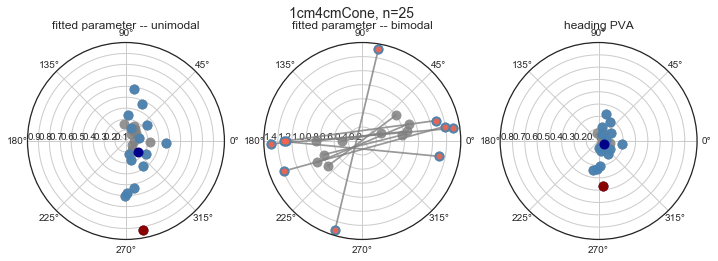

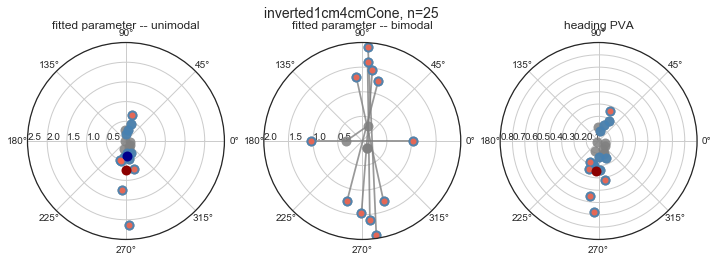

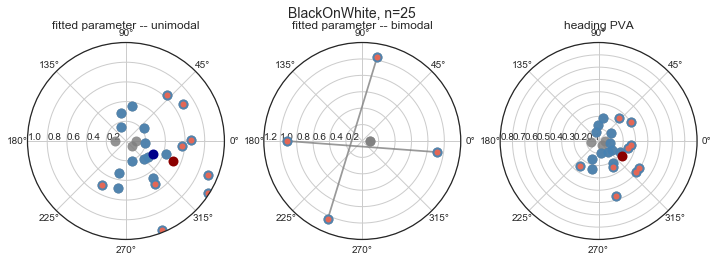

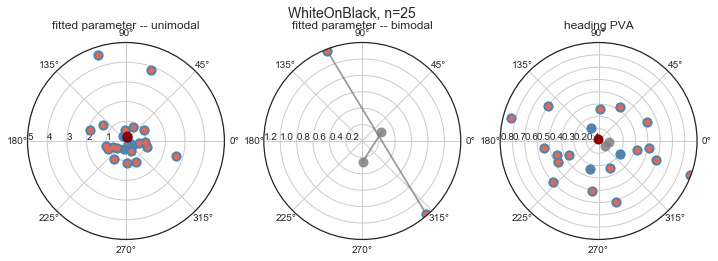

In [42]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)

    #Plot fit results
    fixFig = plt.figure(figsize=(12,4))
    fixFig.suptitle(sceneName+', n='+str(numFlies),fontsize=14)

    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(131,projection='polar')
    ax.plot(vmfits[scene,0,:],vmfits[scene,1,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    #ax.set_rlim(0,np.nanmax(vmfits[:,1,:]))
    ax.set_rlabel_position(180)
    ax.set_title('fitted parameter -- unimodal')
    
    #polar plot of fitted location and shape parameter - bimodal
    ax = fixFig.add_subplot(132,projection='polar')
    ax.plot(vmbmfits[scene,0,:],vmbmfits[scene,2,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmbmfits[scene,1,:],vmbmfits[scene,2,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot([vmbmfits[scene,0,:],vmbmfits[scene,1,:]],[vmbmfits[scene,2,:],vmbmfits[scene,2,:]],'-',color='grey',alpha=0.8)
    ax.plot(vmbmfits[scene,0,goodFit_bm],vmbmfits[scene,2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,1,goodFit_bm],vmbmfits[scene,2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)

    ax.plot(vmbmfits[scene,0,slct_bm],vmbmfits[scene,2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)
    ax.plot(vmbmfits[scene,1,slct_bm],vmbmfits[scene,2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)

    #ax.set_rlim(0,3)#np.nanmax(vmbmfits[:,2,:]))
    ax.set_rlabel_position(180)
    ax.set_title('fitted parameter -- bimodal')

    #polar plot of PVA
    ax = fixFig.add_subplot(133,projection='polar')
    ax.plot(headingPVA[scene,:,0],headingPVA[scene,:,1],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(headingPVA[scene,goodFit,0],headingPVA[scene,goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)

    ax.plot(headingPVA[scene,slct,0],headingPVA[scene,slct,1],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,slct,0],headingPVA[scene,slct,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,0.8)
    ax.set_rlabel_position(180)
    ax.set_title('heading PVA')
    
    #fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMBiModFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

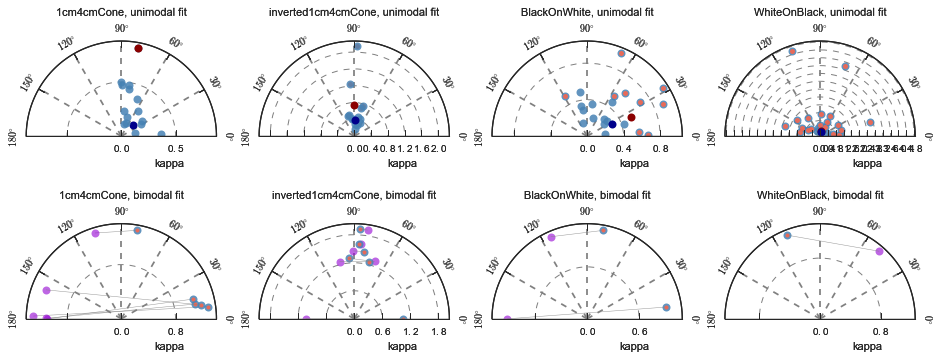

In [124]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

fixFig = plt.figure(figsize=(16,6))

for scene, sceneName in enumerate(sceneNames):
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)

    #polar plot of fitted location and shape parameter - unimodal
    polplt = fractional_polar_axes(fixFig, thlim=(0, 180), rlim=(0, 1.06*np.nanmax(vmfits[scene,1,goodFit])),
                                   step=(30, 0.3), thlabel = sceneName+', unimodal fit',
                                   rlabel='kappa',subplotloc='24'+str(scene+1))
    polplt.plot(abs(vmfits[scene,0,goodFit])*180/np.pi,vmfits[scene,1,goodFit],'o',markersize=8,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    polplt.plot(abs(meandir)*180/np.pi,meanlen,'o', color='darkblue',alpha=1, markersize=8)
    
    polplt.plot(abs(vmfits[scene,0,slct])*180/np.pi,vmfits[scene,1,slct],'.',markersize=10,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    polplt.plot(abs(meandir)*180/np.pi,meanlen,'o', color='darkred',alpha=1, markersize=8)
    
    #polar plot of fitted location and shape parameter - bimodal
    polplt = fractional_polar_axes(fixFig, thlim=(0, 180), rlim=(0, 1.06*np.nanmax(vmbmfits[scene,2,goodFit_bm])),
                                   step=(30, 0.5), thlabel = sceneName+', bimodal fit', 
                                   rlabel='kappa', subplotloc='24'+str(scene+5))
    
    polplt.plot(np.abs(vmbmfits[scene,0,goodFit_bm])*180.0/np.pi,vmbmfits[scene,2,goodFit_bm],'o',markersize=8,color='steelblue',alpha=0.85)
    polplt.plot(np.abs(vmbmfits[scene,1,goodFit_bm])*180.0/np.pi,vmbmfits[scene,2,goodFit_bm],'o',markersize=8,color='darkviolet',alpha=0.6)
    
    polplt.plot([np.abs(vmbmfits[scene,0,goodFit_bm])*180/np.pi,np.abs(vmbmfits[scene,1,goodFit_bm])*180/np.pi],
                [vmbmfits[scene,2,goodFit_bm],vmbmfits[scene,2,goodFit_bm]],
                '-',linewidth = 0.5, color='grey',alpha=0.8)

    polplt.plot(np.abs(vmbmfits[scene,0,slct_bm])*180.0/np.pi,vmbmfits[scene,2,slct_bm],'.',markersize=8,
                color='tomato',alpha=0.85)
    #polplt.plot(np.abs(vmbmfits[scene,1,slct_bm])*180.0/np.pi,vmbmfits[scene,2,slct_bm],'.',markersize=10,color='violet',alpha=0.85)

#fixFig.tight_layout()
#fixFig.savefig(analysisDir + 'circStats/'  + genotype
#               + '_vMBiModFixation3_n'+ str(numFlies) +'.pdf', format='pdf') 

### Selection of data

In [33]:
print('Total number of flies measured: ' + str(numFlies))

for scene,sceneName in enumerate(sceneNames):
    print('\n'+sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    
    print('Number of flies that walked for less than 20% of trial time: ' + str(int(fliesNotWalking[scene])) \
          + ' ('+str(numFlies)+')')
    
    print('Unimodal fits:')
    print('  Number of walking flies for which von Mises was good fit: ' + str(sum(goodFit))\
          + ' ('+str(numFlies-int(fliesNotWalking[scene]))+')')
    print('  Total number of fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmfits[scene,1,:]>kappaTH)) + ' ('+str(numFlies-int(fliesNotWalking[scene]))+')')
    print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmfits[scene,1,goodFit]>kappaTH)) + ' ('+str(sum(goodFit))+')')

    print('Bimodal fits:')
    print('  Number of walking flies for which bimodal von Mises was good fit: ' + str(sum(goodFit_bm))\
          + ' ('+str(sum(~goodFit)-int(fliesNotWalking[scene]))+')')
    print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmbmfits[scene,2,goodFit_bm]>kappaTH)) + ' ('+str(sum(goodFit_bm))+')')

Total number of flies measured: 25

1cm4cmCone
Number of flies that walked for less than 20% of trial time: 0 (25)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 15 (25)
  Total number of fitted distributions with concentration measure kappa > 0.5: 1 (25)
  Number of well fitted distributions with concentration measure kappa > 0.5: 1 (15)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 5 (10)
  Number of well fitted distributions with concentration measure kappa > 0.5: 5 (5)

inverted1cm4cmCone
Number of flies that walked for less than 20% of trial time: 3 (25)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 14 (22)
  Total number of fitted distributions with concentration measure kappa > 0.5: 6 (22)
  Number of well fitted distributions with concentration measure kappa > 0.5: 6 (14)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 6 (8)
  Number of well fitted dist

### Use Rayleigh test on mean fixation location (on selected data, conditioned on good fit with unimodal von Mises)

In [34]:
def RayleighTest(r,n):
    R = n*r
    
    #Rayleigh z
    z_R = n*np.square(r)
    
    #Rayleigh probability approximation
    p_R = np.exp(np.sqrt(1 + 4*n + 4*(np.square(n)-np.square(R))) - (1+2*n))
    
    return z_R, p_R

In [35]:
# ...based on on fitted location parameter mu

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    print('\n'+sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)

    fitSamples = len(vmfits[scene,0,slct])
    
    PVAdir, PVAlen = circmeanvec(vmfits[scene,0,slct],np.ones(fitSamples), high=angleHigh, low=angleLow)

    [z,p] = RayleighTest(PVAlen,fitSamples)

    print('Test statistic z = ' + str(z))
    print('Probability of test statistic p = ' + str(p))
    if (p<0.001):
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    elif (p<0.01): 
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    elif (p<0.05): 
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    else:
        print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')


1cm4cmCone
Test statistic z = 1.0
Probability of test statistic p = 0.465831162611
Accept H0 that sample is drawn from a uniform distribution (p>0.01).

inverted1cm4cmCone
Test statistic z = 2.53665999221
Probability of test statistic p = 0.0741314394904
Accept H0 that sample is drawn from a uniform distribution (p>0.01).

BlackOnWhite
Test statistic z = 4.24563349449
Probability of test statistic p = 0.0103336863679
Reject H0 that sample is drawn from a uniform distribution (p<0.05).
Mean angle = -0.385 (-22.073 deg)

WhiteOnBlack
Test statistic z = 0.0479305982929
Probability of test statistic p = 0.954345413715
Accept H0 that sample is drawn from a uniform distribution (p>0.01).


## Comparison between fixation in 1D and 2D
### Is there a correlation between the location of the fixation peak in 1D and 2D?

BlackOnWhite vs 1cm4cmCone
WhiteOnBlack vs inverted1cm4cmCone


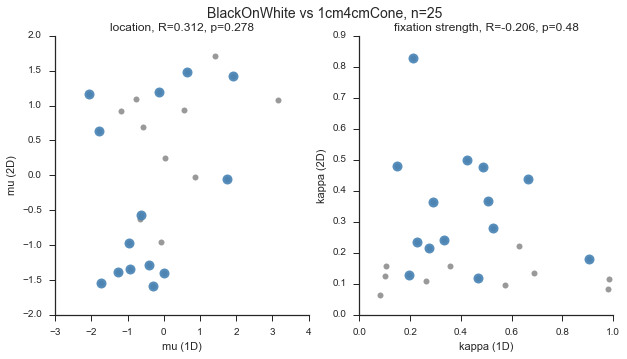

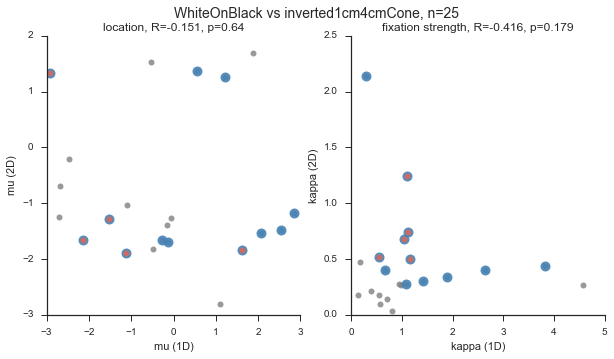

In [36]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

groups = [(0,2),(1,3)]

for ind, group in enumerate(groups):
    scene1D = sceneNames[group[1]]
    scene2D = sceneNames[group[0]]
    
    print(scene1D + ' vs ' + scene2D)
    
    #Plot fit results
    fix1Dvs2DFig = plt.figure(figsize=(10,5))
    fix1Dvs2DFig.suptitle(scene1D + ' vs ' + scene2D + ', n='+str(numFlies),fontsize=14)
    
    ## Unimodal
    goodFit1D = np.logical_and(np.logical_or(vmfits[group[1],3,:]>0.1, headingPVA[group[1],:,1]>0.5),\
                              ~np.isnan(headingPVA[group[1],:,1]))
    goodFit2D = np.logical_and(np.logical_or(vmfits[group[0],3,:]>0.1, headingPVA[group[0],:,1]>0.5),\
                              ~np.isnan(headingPVA[group[0],:,1]))
    goodFit = np.logical_and(goodFit1D,goodFit2D)
    
    slct1D = np.logical_and(vmfits[group[1],1,:]>kappaTH,goodFit1D)
    slct2D = np.logical_and(vmfits[group[0],1,:]>kappaTH,goodFit2D)
    slct = np.logical_and(slct1D,slct2D)

    #correlation between fixation location in 1D and 2D
    ax = fix1Dvs2DFig.add_subplot(121)
    ax.plot(vmfits[group[1],0,:],vmfits[group[0],0,:],'o',markersize=6,color='grey',alpha=0.8)
    ax.plot(vmfits[group[1],0,goodFit],vmfits[group[0],0,goodFit],'o',markersize=10,color='steelblue',alpha=0.9)
    ax.plot(vmfits[group[1],0,slct],vmfits[group[0],0,slct],'.',markersize=12,color='tomato',alpha=0.7)
    ax.set_xlabel('mu (1D)')
    ax.set_ylabel('mu (2D)')
    pR, pp = sts.pearsonr(vmfits[group[1],0,goodFit], vmfits[group[0],0,goodFit])
    ax.set_title('location, R='+str(round(pR,3))+', p='+str(round(pp,3)))
    myAxisTheme(ax)
    
    #correlation between fixation strength in 1D and 2D
    ax = fix1Dvs2DFig.add_subplot(122)
    ax.plot(vmfits[group[1],1,:],vmfits[group[0],1,:],'o',markersize=6,color='grey',alpha=0.8)
    ax.plot(vmfits[group[1],1,goodFit],vmfits[group[0],1,goodFit],'o',markersize=10,color='steelblue',alpha=0.9)
    ax.plot(vmfits[group[1],1,slct],vmfits[group[0],1,slct],'.',markersize=12,color='tomato',alpha=0.7)
    ax.set_xlabel('kappa (1D)')
    ax.set_ylabel('kappa (2D)')
    pR, pp = sts.pearsonr(vmfits[group[1],1,goodFit], vmfits[group[0],1,goodFit])
    ax.set_title('fixation strength, R='+str(round(pR,3))+', p='+str(round(pp,3)))
    myAxisTheme(ax)
    
    #fix1Dvs2DFig.tight_layout()
    fix1Dvs2DFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + scene1D + 'Vs' + scene2D
                   + '-Fixation_n'+ str(numFlies) +'.pdf', format='pdf') 

## Peak-based analysis

In [349]:
def findFixationPeak(N,flySignal):
    maxSignal = np.hstack((np.repeat(flySignal[0],N),flySignal,np.repeat(flySignal[-1],N)))
    maxSignal = np.convolve(maxSignal, np.ones((N,))/N, mode='same')
    maxSignal = maxSignal[N:-N]
    peak = np.where(maxSignal == np.max(maxSignal))[0]
    
    
    return peak[0]

In [350]:
def findFullWidthHalfMax(y,peak,low):
    #find half maximum
    halfMax = np.median(y)#(y[peak]-y[low])/2.0 + y[low]
    # walk 'downhill' until below half max
    leftW = peak
    rightW = peak
    while(y[leftW]>halfMax):
        leftW = leftW-1
        if(leftW<0):
            leftW = len(y)-1
            
    while(y[rightW]>halfMax):
        rightW = rightW+1
        if(rightW>len(y)-1):
            rightW = 0
        
    return [leftW,rightW]

In [351]:
fullBins = 36
peaks_fullGamma = np.nan*np.ones((4,numFlies,2))
FWHM_fullGamma = np.nan*np.ones((4,numFlies))
densityFlag = True

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]
    print('\n'+scenename+'\n')
    
    for fly in range(numFlies):

        #print(flyIDs[fly])

        querystring = '(sceneName=="' + scenename + '") & (flyID =="' + flyIDs[fly] +  '")'
        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()

        if sum(moving)<=0.2*len(moving):
            continue

        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=fullBins)
        if densityFlag:
            normFactor = nhead.sum()
        else:
            normFactor = 1.0

        currFlySignal = nhead/normFactor
        fulledges = edges[:-1]+np.diff(edges)/2

        # find peak of heading:
        N=5
        peak = findFixationPeak(N,currFlySignal)
        low = findFixationPeak(N,-1*currFlySignal)
        peak = findFixationPeak(N,currFlySignal)
        peaks_fullGamma[scene,fly,:] = [fulledges[peak],currFlySignal[peak]]
        
        #find FWHM
        [leftW, rightW] = findFullWidthHalfMax(currFlySignal,peak,low)

        FWHM = np.abs((fulledges[rightW]+np.pi)-(fulledges[leftW]+np.pi))
        
        FWHM_fullGamma[scene,fly] = FWHM



1cm4cmCone


inverted1cm4cmCone


BlackOnWhite


WhiteOnBlack



In [352]:
try:
    mkdir(analysisDir + sep + 'peakAnalysis' + sep)
except OSError:
    print('Analysis directory already exists.')
    
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'peaksLoc_fullGamma.csv', peaks_fullGamma[:,:,0].T,
           fmt="%s", delimiter=',', newline='\n', 
           header='1cm4cmCone, inverted1cm4cmCone, BlackOnWhite, WhiteOnBlack', footer='', comments='# ')
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'peaksSize_fullGamma.csv', peaks_fullGamma[:,:,1].T,
           fmt="%s", delimiter=',', newline='\n', 
           header='1cm4cmCone, inverted1cm4cmCone, BlackOnWhite, WhiteOnBlack', footer='', comments='# ')
np.savetxt(analysisDir + sep + 'peakAnalysis' + sep + 'FWHM_fullGamma.csv', FWHM_fullGamma.T,
           fmt="%s", delimiter=',', newline='\n',
           header='1cm4cmCone, inverted1cm4cmCone, BlackOnWhite, WhiteOnBlack', footer='', comments='# ')

In [353]:
sceneIDList = [2,0,3,1] #[0]

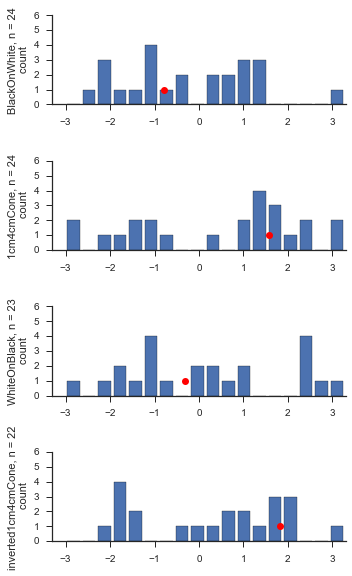

In [354]:
wherePeaksFig = plt.figure(figsize=(5,2*len(sceneIDList)))
histRange = (-np.pi, np.pi)
fullHistBins = 18

for sceneind, scene in enumerate(sceneIDList):
    scenePlt = wherePeaksFig.add_subplot(len(sceneNames),1,sceneind+1)
    nhead, edges = np.histogram(peaks_fullGamma[scene,~np.isnan(peaks_fullGamma[scene,:,0]),0],range=histRange,bins=fullHistBins)
    scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=1.6*np.pi/fullHistBins)
    nanMask = ~np.isnan(peaks_fullGamma[scene,:,0])
    meanx = np.arctan2(np.median(np.sin(peaks_fullGamma[scene,nanMask,0])),np.median(np.cos(peaks_fullGamma[scene,nanMask,0])));
    scenePlt.plot(meanx,1,'ro')
    sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[scene,:,0]))))
    scenePlt.set_ylabel(sceneNames[scene]+', n = '+sampleSize+'\n count')
    scenePlt.set_xlim(-np.pi*1.05,np.pi*1.05)
    scenePlt.set_ylim(0,6)
    myAxisTheme(scenePlt)
wherePeaksFig.tight_layout()   

wherePeaksFig.savefig(analysisDir + 'peakAnalysis' + sep + genotypeSex + '_peakLocHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')

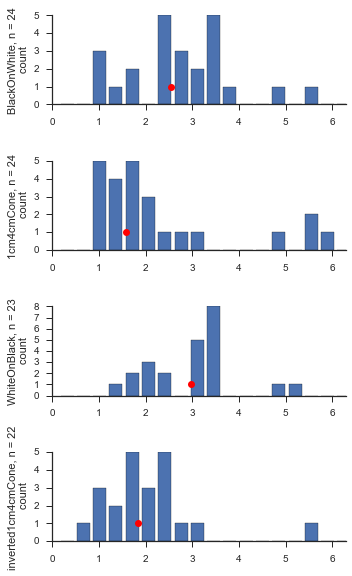

In [355]:
widthPeaksFig = plt.figure(figsize=(5,2*len(sceneIDList)))
histRange = (0,2*np.pi)
fullHistBins = 18
for sceneind, scene in enumerate(sceneIDList):
    scenePlt = widthPeaksFig.add_subplot(len(sceneNames),1,sceneind+1)
    nhead, edges = np.histogram(FWHM_fullGamma[scene,~np.isnan(FWHM_fullGamma[scene,:])],range=histRange,bins=fullHistBins)
    scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=1.6*np.pi/fullHistBins)
    nanMask = ~np.isnan(FWHM_fullGamma[scene,:])
    meanx = np.median(FWHM_fullGamma[scene,nanMask])
    scenePlt.plot(meanx,1,'ro')
    sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[scene,:,0]))))
    scenePlt.set_ylabel(sceneNames[scene]+', n = '+sampleSize+'\n count')
    scenePlt.set_xlim(0,2*np.pi)
    myAxisTheme(scenePlt)
widthPeaksFig.tight_layout()

widthPeaksFig.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakWidthHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')

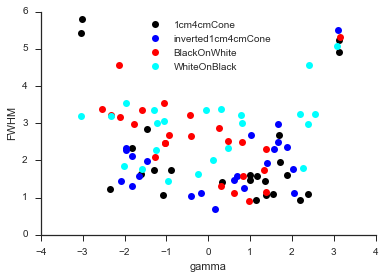

In [356]:
posVsWidth = plt.figure(figsize=(6,4))

posVsWidthPlt = posVsWidth.add_subplot(111)
colcode = ['black','blue','red','cyan']
for scene in range(len(sceneNames)):
    posVsWidthPlt.plot(peaks_fullGamma[scene,:,0]+0.1*np.random.rand(len(peaks_fullGamma[scene,:,0])),
                       FWHM_fullGamma[scene,:]+0.1*np.random.rand(len(peaks_fullGamma[scene,:,0])),
                       'o',color = colcode[scene])
posVsWidthPlt.legend(sceneNames,loc=9)
posVsWidthPlt.set_xlabel('gamma')
posVsWidthPlt.set_ylabel('FWHM')
myAxisTheme(posVsWidthPlt)

posVsWidth.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakPosVsWidth_n'+str(numFlies)+'.pdf', format = 'pdf')

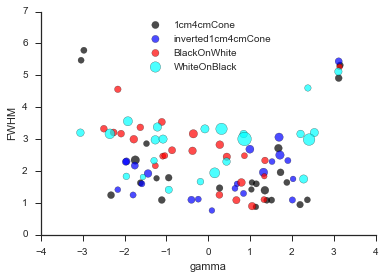

In [357]:
posVsWidth = plt.figure(figsize=(6,4))

posVsWidthPlt = posVsWidth.add_subplot(111)
colcode = ['black','blue','red','cyan']
for scene in range(len(sceneNames)):
    posVsWidthPlt.scatter(peaks_fullGamma[scene,:,0]+0.1*np.random.rand(len(peaks_fullGamma[scene,:,0])),
                          FWHM_fullGamma[scene,:]+0.1*np.random.rand(len(peaks_fullGamma[scene,:,0])),
                          c=colcode[scene],s=1000*peaks_fullGamma[scene,:,1],alpha=0.7)
posVsWidthPlt.legend(sceneNames,loc=9)
posVsWidthPlt.set_xlabel('gamma')
posVsWidthPlt.set_ylabel('FWHM')
myAxisTheme(posVsWidthPlt)

posVsWidth.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakPosVsWidthPeak_n'+str(numFlies)+'.pdf', format = 'pdf')

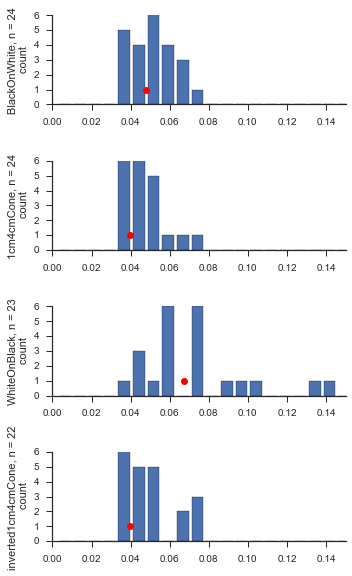

In [358]:
wherePeaksFig = plt.figure(figsize=(5,2*len(sceneIDList)))
maxSize = 0.15
histRange = (0,maxSize)
fullHistBins = 20
for sceneind, scene in enumerate(sceneIDList):
    scenePlt = wherePeaksFig.add_subplot(len(sceneNames),1,sceneind+1)
    nhead, edges = np.histogram(peaks_fullGamma[scene,~np.isnan(peaks_fullGamma[scene,:,1]),1],range=histRange,bins=fullHistBins)
    scenePlt.bar(edges[:-1]+np.diff(edges)/2,nhead,width=0.8*maxSize/fullHistBins)
    nanMask = ~np.isnan(peaks_fullGamma[scene,:,1])
    meanx = np.median(peaks_fullGamma[scene,nanMask,1])
    scenePlt.plot(meanx,1,'ro')
    sampleSize = str(sum(np.squeeze(~np.isnan(peaks_fullGamma[scene,:,0]))))
    scenePlt.set_ylabel(sceneNames[scene]+', n = '+sampleSize+'\n count')
    scenePlt.set_xlim(0,maxSize)
    scenePlt.set_ylim(0,6)
    myAxisTheme(scenePlt)
wherePeaksFig.tight_layout()   

wherePeaksFig.savefig(analysisDir + sep + 'peakAnalysis' + sep + genotypeSex + '_peakHeightHistogram_n'+str(numFlies)+'.pdf', format = 'pdf')